In [1]:
import pandas as pd 
import numpy as np

In [2]:
import datetime 
from datetime import date

In [3]:
# visualisation 
import seaborn as sns
import matplotlib.pyplot as plt 

# Palettes des couleurs 
from palettable.colorbrewer.qualitative import Pastel1_7

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# Visualisation avec plotly
import plotly.express as px
import json

In [4]:
# statistiques
import scipy.stats as st # coefficient de Pearson
# Calculs statistiques
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from scipy.stats import shapiro

In [5]:
# Pévisions des modèles saisonniers
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from functions import*
import statsmodels.api as sm

# Modèles SARIMAX
from statsmodels.tsa.statespace.sarimax import*
from statsmodels.stats.diagnostic import acorr_ljungbox

# Dataframe holidays_events.csv

Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

# Train.csv


The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [6]:
# Dataframe holidays event
holidays_event = pd.read_csv(r"C:\Users\Utilisateur\projet 8\holidays_events.csv")
holidays_event.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [7]:
holidays_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [8]:
# On va transformer la date au format datetime
print("Date de début:", holidays_event.date.min()) # date de début 
print("Date de fin: ", holidays_event.date.max()) # Date de fin
holidays_event.loc[holidays_event["date"] == "2016-04-16"] # jour spéciale tremblement de terre de magnétude 7.8

Date de début: 2012-03-02
Date de fin:  2017-12-26


date   type    locale locale_name       description  transferred
219  2016-04-16  Event  National     Ecuador  Terremoto Manabi        False

In [9]:
print("\nColonne type: ",  holidays_event.type.unique())
print("\nColonne locale: ",  holidays_event.locale.unique())
print("\nColonne locale_name:\n\n", holidays_event.locale_name.unique())
print("\nColonne transferred\n\n: ", holidays_event.locale_name.unique())


Colonne type:  ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']

Colonne locale:  ['Local' 'Regional' 'National']

Colonne locale_name:

 ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']

Colonne transferred

:  ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


In [10]:
# Nombre de dates transférées

transferred_days = holidays_event.loc[holidays_event["transferred"] == True]
print("Nombre de dates transférées: ", transferred_days.shape[0])
# On a 12 dates qui on été transférés

Nombre de dates transférées:  12


In [11]:
# Nombre de fêtes par localité 
Holiday_local = holidays_event.loc[(holidays_event["type"] == "Holiday") & (holidays_event["locale"] == "Local")]
Holiday_regional = holidays_event.loc[(holidays_event["type"] == "Holiday") & (holidays_event["locale"] == "Regional")]
Holiday_national = holidays_event.loc[(holidays_event["type"] == "Holiday") & (holidays_event["locale"] == "National")]
print("Fêtes locales: ", Holiday_local.shape[0])
print("Fêtes régionales: ", Holiday_regional.shape[0])
print("Fêtes nationales: ", Holiday_national.shape[0])

Fêtes locales:  137
Fêtes régionales:  24
Fêtes nationales:  60


 # Dataframe Train

In [12]:
# Dataframe Train
missing_values = ["n/a", "na", "--", "", " "]
train = pd.read_csv(r"C:\Users\Utilisateur\projet 8\train.csv", na_values = missing_values)
#train["date"] = pd.to_datetime(train["date"]) # On convertit la date au format date
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [13]:
print("date de début:",   train.date.min())
print("date de fin:",   train.date.max())
train.loc[train["date"] == "2016-04-16"].head(2) # Durant le tremblement de terre il y a eu de l'activité 

date de début: 2013-01-01
date de fin: 2017-08-15


id        date  store_nbr      family  sales  onpromotion
2134836  2134836  2016-04-16          1  AUTOMOTIVE    6.0            0
2134837  2134837  2016-04-16          1   BABY CARE    0.0            0

In [14]:
train_store_nbr = len(train["store_nbr"].unique()) # 54 Magasins
train_family = train["family"].unique().shape[0]
print( "Nombre de magasins: ", train_store_nbr)
print( "Nombre de type de produits différents : ", train_family)

Nombre de magasins:  54
Nombre de type de produits différents :  33


## Dataframe Train et holiday_event

In [15]:
train_holiday = train.merge(holidays_event, left_on = "date", right_on = "date", how = "left")
train_holiday.head(2)

id        date  store_nbr      family  sales  onpromotion     type  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1  2013-01-01          1   BABY CARE    0.0            0  Holiday   

     locale locale_name         description transferred  
0  National     Ecuador  Primer dia del ano       False  
1  National     Ecuador  Primer dia del ano       False

## Dataframe store 

In [16]:
store = pd.read_csv(r"C:\Users\Utilisateur\projet 8\stores.csv")
store = store.rename(columns = {"type": "type_store"})
store.head()

store_nbr           city                           state type_store  \
0          1          Quito                       Pichincha          D   
1          2          Quito                       Pichincha          D   
2          3          Quito                       Pichincha          D   
3          4          Quito                       Pichincha          D   
4          5  Santo Domingo  Santo Domingo de los Tsachilas          D   

   cluster  
0       13  
1       13  
2        8  
3        9  
4        4

In [17]:
# On associe les deux dataframes
train_hoday_store = train_holiday.merge(store, right_on = "store_nbr", left_on = "store_nbr", how = "left")
train_hoday_store.head()

id        date  store_nbr      family  sales  onpromotion     type  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1  2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2  2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4  2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description transferred   city      state  \
0  National     Ecuador  Primer dia del ano       False  Quito  Pichincha   
1  National     Ecuador  Primer dia del ano       False  Quito  Pichincha   
2  National     Ecuador  Primer dia del ano       False  Quito  Pichincha   
3  National     Ecuador  Primer dia del ano       False  Quito  Pichincha   
4  National     Ecuador  Primer dia del ano       False  Quito  Pichincha   

  type_store  cluster  
0          D       13  
1          D       13  
2          D       13  
3          D       13  
4          D       13

In [18]:
# Description des données 
train_hoday_store.describe(include = "object")

date           family     type    locale locale_name  \
count      3054348          3054348   502524    502524      502524   
unique        1684               33        6         3          24   
top     2014-06-25  HOME APPLIANCES  Holiday  National     Ecuador   
freq          7128            92556   304722    261954      261954   

       description transferred     city      state type_store  
count       502524      502524  3054348    3054348    3054348  
unique         101           2       22         16          5  
top       Carnaval       False    Quito  Pichincha          D  
freq         17820      486486  1018116    1074678    1018116

## Earthquake_day

In [19]:
# Restriction des ventes du jour du tremblement de terre
earthquake  = train_hoday_store.loc[train_hoday_store["date"] == "2016-04-16"] 

# Groupage par family
earthquake_grp =earthquake.groupby(by = ["family"]).agg({"sales" : "sum"}).reset_index().sort_values(by = "sales", ascending = False).head(20)



Vente totale le jour du tremblement de terre: 862121


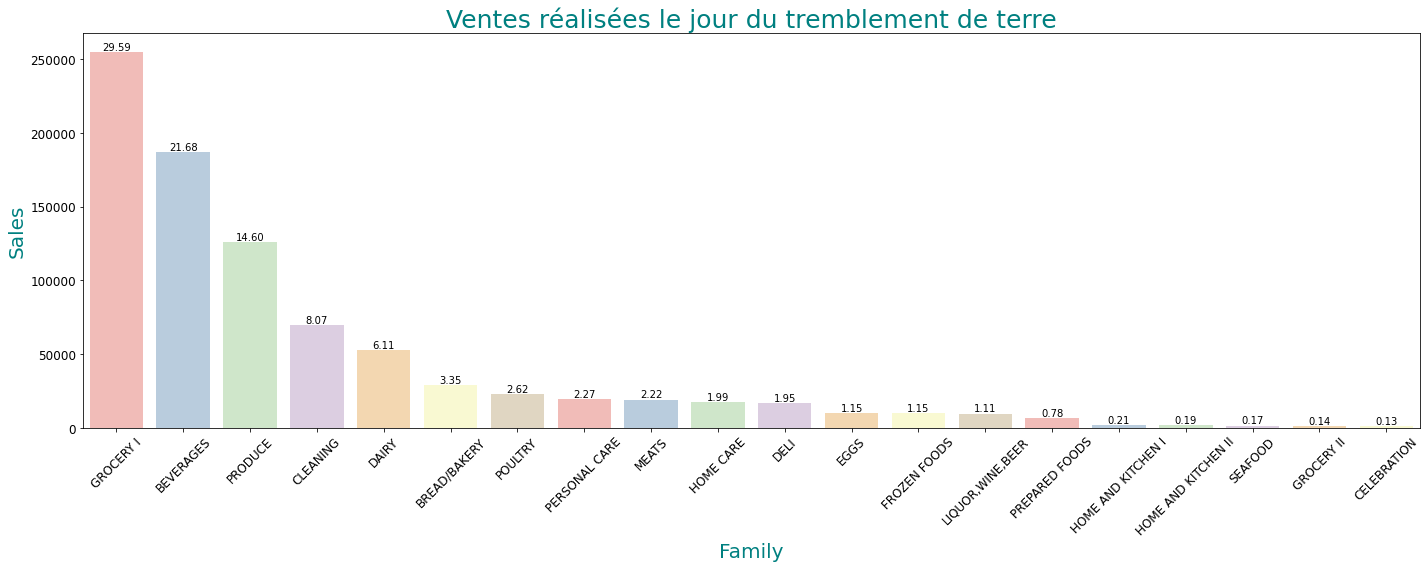

In [20]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# Plot
# Représentation des ventes par secteurs d'activité
fig, ax = plt.subplots(figsize = (20,8))


sns.barplot(y = "sales", x = "family",  data = earthquake_grp, 
                        palette = Pastel1_7.hex_colors)
plt.title("Top 10 des secteurs d'activité sans le tremblement de terre", fontsize = 12)




# Annotation sur les barplots


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/earthquake["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

print("\nVente totale le jour du tremblement de terre:", round(earthquake.sales.sum()))
   
# Métadonnées 
plt.title( "Ventes réalisées le jour du tremblement de terre", fontsize = 25, color = "teal")
plt.ylabel("Sales", fontsize = 20, color = "teal")
plt.xlabel("Family", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.show()





In [21]:
#train_hoday = train_holiday.dropna()

In [22]:
def weekend(date):
  import datetime
  weekend = []
  a = pd.to_datetime(date)
  for i in range(len(a)):
    if a.iloc[i].weekday() >= 5 :
      weekend.append(1)
    else:
      weekend.append(0)
  return weekend


#Weekday
def weekday(date):
    import datetime
    weekday = []
    a = pd.to_datetime(date)
    for i in range(len(a)):
        weekday.append(a.iloc[i].weekday())
    return weekday


In [23]:
def split_year(time):
  return int(time.split('-')[0])

def split_month(time):
  return int(time.split('-')[1])


def split_day(time):
  return int(time.split('-')[2])

In [24]:
train_hoday_store['weekend'] = weekend(train_hoday_store['date'])
train_hoday_store['weekday'] = weekday(train_hoday_store['date'])

train_hoday_store['Year'] = train_hoday_store['date'].apply(split_year) # année
train_hoday_store['Month'] = train_hoday_store['date'].apply(split_month) # Mois de l'année
train_hoday_store['day'] = train_hoday_store['date'].apply(split_day)# jour de l'année

train_hoday_store["date"] = pd.to_datetime(train_hoday_store["date"])
train_hoday_store['quarter'] =pd.PeriodIndex(train_hoday_store['date'] ,freq='Q') # trimestre
train_hoday_store.head()


id       date  store_nbr      family  sales  onpromotion     type  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1 2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2 2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4 2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description  ...   city      state type_store  \
0  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
1  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
2  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
3  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
4  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   

  cluster  weekend  weekday  Year  Month  day  quarter  
0      13        0        1  2013      1    1   2013Q1  
1      13        0        1  2013      1    1   2013Q1  
2      13        0        1  2013      1    1   2013Q1  
3      13        0        1  2013      1    1   2013Q1  
4      13        0        1  2013      1    1   2013Q1  

[5 rows x 21 columns]

## Analyse des données

In [25]:
#Le dateset holiday_event va  du 02/03/2012 au 26/12/2017
#Le dataset train va du 01/01/2013 au 15/08/2017

# Les dates de début
a1 = date(2012,3,2) # début holidays_events
a2 = date(2013,1,1) # debut train
print("Retard de début entre les deux datasets: ", (a2.year-a1.year)*12 + (a2.month -a1.month),"mois")
print("Le dataset holiday_event commence avec 10 mois de retard par rapport au dataset train")

#Les dates de fin
a3 = date(2017,12,26) # fin de holiday_event
a4 = date(2017,8,15) # fin train
print("\n\nRetard entre les deux: ", (a4.year - a3.year)*12 + (a4.month -a3.month), "mois")
print("Le dataset holiday_event fini 4 en avance à comparer avec le data train")


Retard de début entre les deux datasets:  10 mois
Le dataset holiday_event commence avec 10 mois de retard par rapport au dataset train


Retard entre les deux:  -4 mois
Le dataset holiday_event fini 4 en avance à comparer avec le data train


### Valeurs manquantes

In [26]:
# Valeurs manquantes 
train_holiday_missing = train_hoday_store[train_hoday_store.isna().any(axis = 1)]
print("Date de début des valeurs manquantes",train_holiday_missing.date.min())
print("Date de fin des valeurs manquantes",train_holiday_missing.date.max())

Date de début des valeurs manquantes 2013-01-02 00:00:00
Date de fin des valeurs manquantes 2017-08-14 00:00:00


In [27]:
train_hoday = train_hoday_store.dropna()
train_hoday.head()

id       date  store_nbr      family  sales  onpromotion     type  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1 2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2 2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4 2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description  ...   city      state type_store  \
0  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
1  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
2  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
3  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
4  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   

  cluster  weekend  weekday  Year  Month  day  quarter  
0      13        0        1  2013      1    1   2013Q1  
1      13        0        1  2013      1    1   2013Q1  
2      13        0        1  2013      1    1   2013Q1  
3      13        0        1  2013      1    1   2013Q1  
4      13        0        1  2013      1    1   2013Q1  

[5 rows x 21 columns]

## Comparer les ventes par secteur d'activité 

### Family vs Sales

In [28]:
#Les ventes réalisées en tenant compte du tremblement de terre
# Les données
tr_day_fam = train_hoday[["date","family", "sales"]]
tr_day_fam_grp =tr_day_fam.groupby(by = ["family"]).agg({"sales" : "sum"}).reset_index().sort_values(by = "sales", ascending = False).head(20)


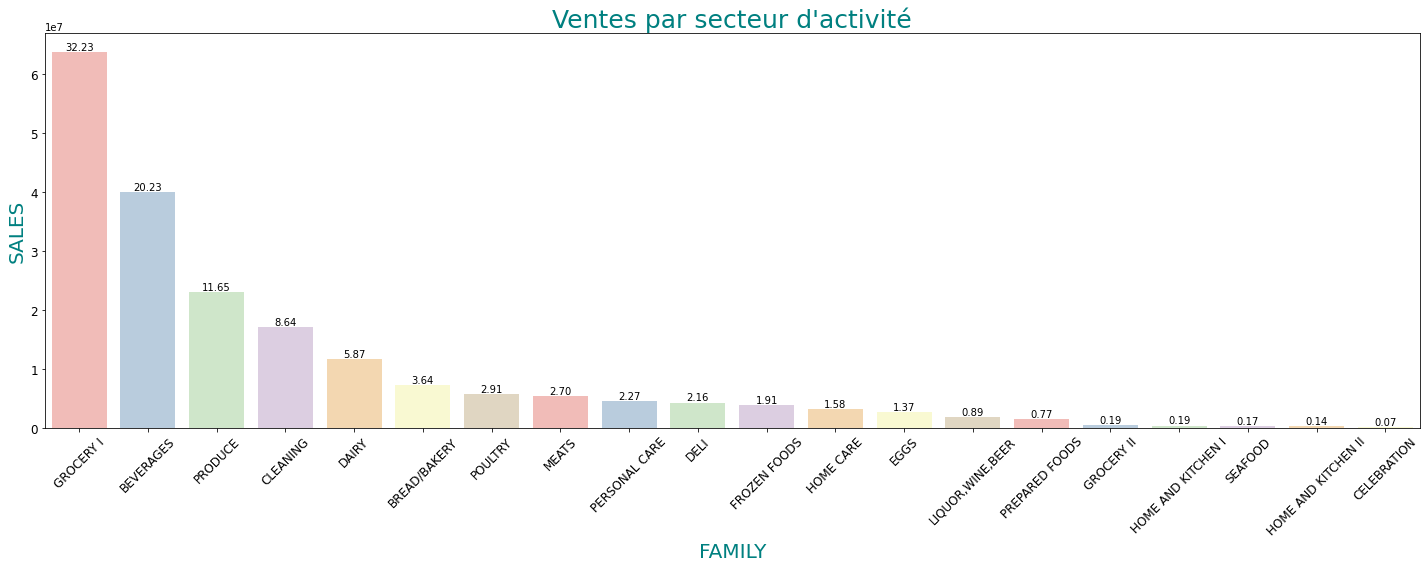

In [29]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# Plot
#Top 10 des ventes par secteurs d'activité
fig, ax = plt.subplots(figsize = (20,8))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "family",  data = tr_day_fam_grp, 
                        palette = Pastel1_7.hex_colors)




# Annotation sur le graphique 
for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/tr_day_fam["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
# Métadonnées 
plt.title( "Ventes par secteur d'activité", fontsize = 25, color = "teal")
plt.ylabel("SALES", fontsize = 20, color = "teal")
plt.xlabel("FAMILY", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.show()

### Family vs Sales on promotion (L'impacte des promotions sur les ventes)

In [30]:
onpromotion = train_hoday[["date","family", "sales", "onpromotion"]]
onpromotion_0 = onpromotion.loc[onpromotion["onpromotion"] == 0] # Sans promotion 
onpromotion_1 = onpromotion.loc[onpromotion["onpromotion"] != 0] # Avec promotion
#onpromotion_1

ventes totales: 197926495
ventes sans promo: 57523350.4 ; Ce qui représente un pourcentage de:  29.1
ventes avec promo: 140403145.0 ; Ce qui représente un pourcentage de:  70.9
La proportion des ventes avec promotion est de:  23


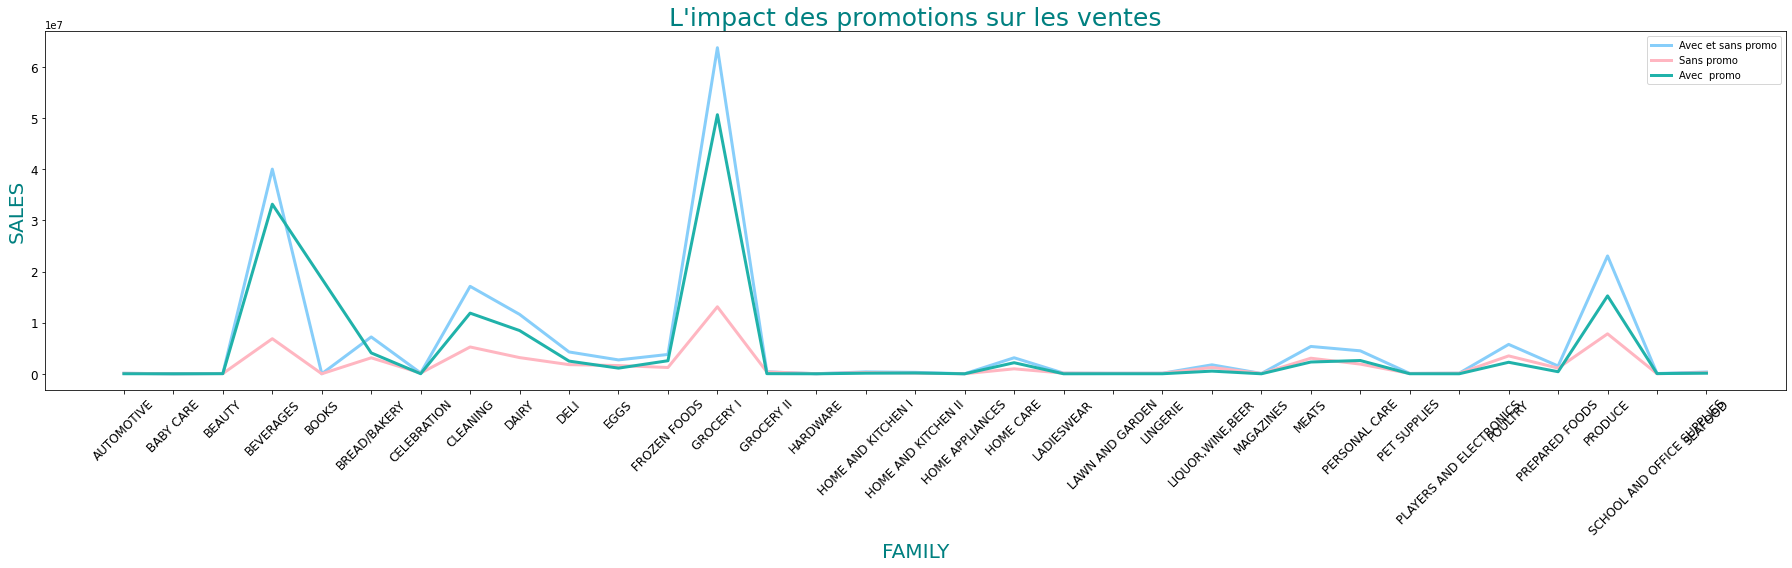

In [31]:
# Pametres requis 
plt.figure(figsize = (25,8))

onpromotion = train_hoday[["date","family", "sales", "onpromotion"]]
onpromotion_gr = onpromotion.groupby(by="family").agg({"sales" : "sum"}).reset_index()

onpromotion_0 = onpromotion.loc[onpromotion["onpromotion"] == 0]
onpromotion_0_gr = onpromotion_0.groupby(by="family").agg({"sales" : "sum"}).reset_index()
onpromotion_1 = onpromotion.loc[onpromotion["onpromotion"] != 0]
onpromotion_1_gr = onpromotion_1.groupby(by="family").agg({"sales" : "sum"}).reset_index()

tr_day_fam_grp1 =tr_day_fam.groupby(by = ["family"]).agg({"sales" : "sum"}).reset_index()


                     
# Caractéristiques du tracé des courbes
plt.plot(onpromotion_gr["family"], onpromotion_gr["sales"], color = 'lightskyblue', label = "Avec et sans promo", lw =3)
plt.plot(onpromotion_0_gr["family"],onpromotion_0_gr["sales"], color = 'lightpink', label = "Sans promo", lw =3)
plt.plot(onpromotion_1_gr["family"],onpromotion_1_gr["sales"], color = 'lightseagreen', label = "Avec  promo", lw =3)

# Métadonnées 
plt.title( "L'impact des promotions sur les ventes", fontsize = 25, color = "teal")
plt.ylabel("SALES", fontsize = 20, color = "teal")
plt.xlabel("FAMILY", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend()

print("ventes totales:", round(onpromotion.sales.sum()))

print("ventes sans promo:", round(onpromotion_0_gr['sales'].sum(), 1), "; Ce qui représente un pourcentage de: ",
                            round(100*onpromotion_0_gr['sales'].sum()/onpromotion.sales.sum(),1))

print("ventes avec promo:", round(onpromotion_1_gr['sales'].sum(), 1), "; Ce qui représente un pourcentage de: ", 
                            round(100*onpromotion_1_gr['sales'].sum()/onpromotion.sales.sum(),1))
print("La proportion des ventes avec promotion est de: ", round(100 *len(onpromotion_1)/len(onpromotion)))

### Analyse des ventes de la colonne "type"

In [32]:
# On fait une restricition sur les colonnes family, sales, type et onpromotion
type_hoday = train_hoday[["family","sales", "type", "onpromotion"]]
type_hoday.head(2)

family  sales     type  onpromotion
0  AUTOMOTIVE    0.0  Holiday            0
1   BABY CARE    0.0  Holiday            0

#### Holiday

Vente totale Holiday: 109222668
ventes sans promo: 36975078 ; Ce qui représente un pourcentage de:  34
ventes avec promo: 72247590 ; Ce qui représente un pourcentage de:  66
La proportion des ventes avec promotion est de:  20


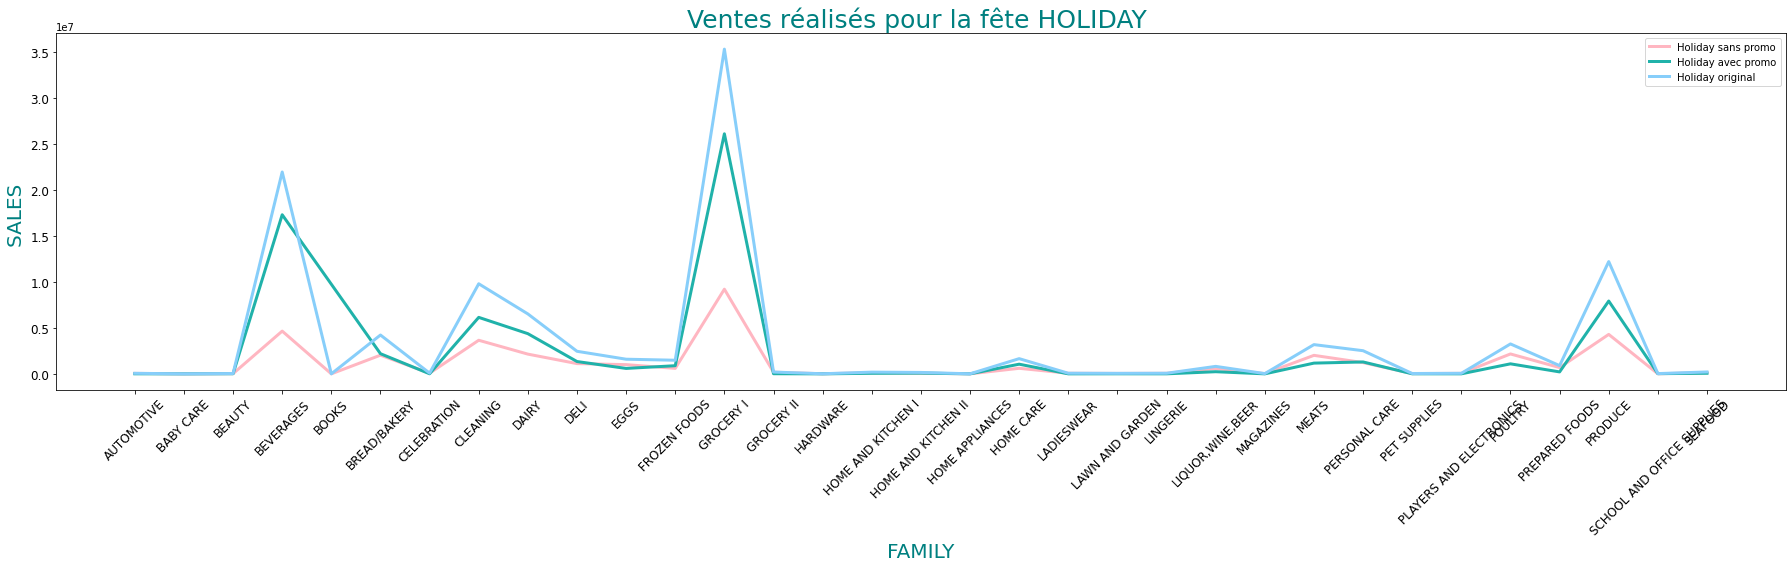

In [33]:
# Type = Holiday
# holiday original
type_Holiday_origine = type_hoday.loc[type_hoday["type"] == "Holiday"]
type_Holiday_original_gr = type_Holiday_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
type_Holiday = type_Holiday_origine.loc[(type_Holiday_origine["type"] == "Holiday") & (type_Holiday_origine["onpromotion"] == 0)]
type_Holiday_0_gr = type_Holiday.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
type_Holiday_on = type_Holiday_origine.loc[(type_Holiday_origine["type"] == "Holiday") & (type_Holiday_origine["onpromotion"] != 0)]
type_Holiday_1_gr = type_Holiday_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pametres requis 
plt.figure(figsize = (25,8))

# Holiday
plt.plot(type_Holiday_0_gr["family"],type_Holiday_0_gr["sales"], color = 'lightpink', label = "Holiday sans promo", lw = 3)
plt.plot(type_Holiday_1_gr["family"],type_Holiday_1_gr["sales"], color = 'lightseagreen', label = "Holiday avec promo", lw =3)
plt.plot(type_Holiday_original_gr["family"],type_Holiday_original_gr["sales"], color = 'lightskyblue', label = "Holiday original", lw =3)

# Métadonnées 
plt.title( "Ventes réalisés pour la fête HOLIDAY ", fontsize = 25, color = "teal")
plt.ylabel("SALES ", fontsize = 20, color = "teal")
plt.xlabel("FAMILY", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend()

print("Vente totale Holiday:", round(type_Holiday_origine["sales"].sum()))

print("ventes sans promo:", round(type_Holiday_0_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_Holiday_0_gr['sales'].sum()/type_Holiday_origine.sales.sum()))

print("ventes avec promo:", round(type_Holiday_1_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_Holiday_1_gr['sales'].sum()/type_Holiday_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_Holiday_on)/len(type_Holiday_origine)))

#### Event

Vente totale Event: 42477469
ventes sans promo: 8003433 ; Ce qui représente un pourcentage de:  19
ventes avec promo: 34474036 ; Ce qui représente un pourcentage de:  81
La proportion des ventes avec promotion est de:  29


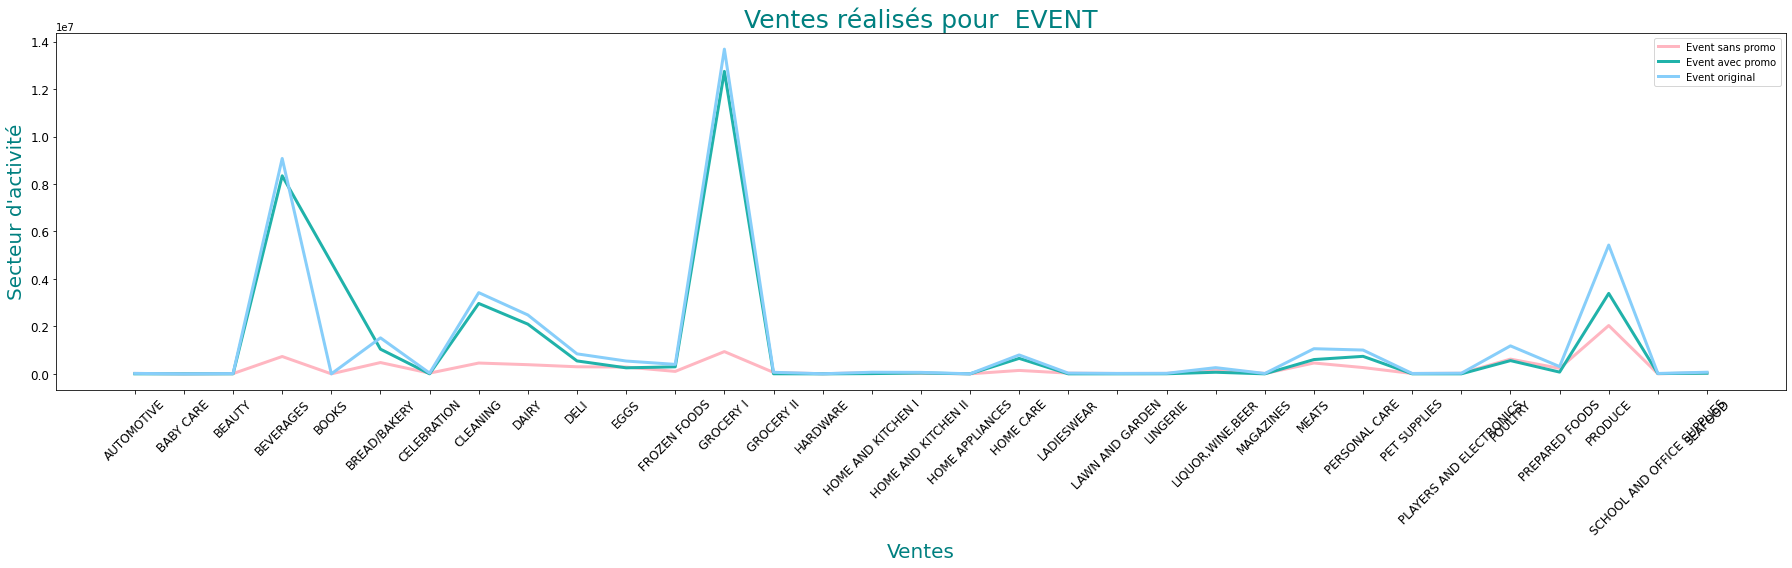

In [34]:
# Type = Event
type_event_origine = type_hoday.loc[type_hoday["type"] == "Event"]
type_event_original_gr = type_event_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

type_event = type_hoday.loc[(type_hoday["type"] == "Event") & (type_hoday["onpromotion"] == 0)]
type_event_on = type_hoday.loc[(type_hoday["type"] == "Event") & (type_hoday["onpromotion"] != 0)]

type_event_0_gr = type_event.groupby(by="family").agg({"sales" : "sum"}).reset_index()
type_event_1_gr = type_event_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))


# Caractéristiques du tracé des courbes

plt.plot(type_event_0_gr["family"],type_event_0_gr["sales"], color = 'lightpink', label = "Event sans promo", lw = 3)
plt.plot(type_event_1_gr["family"],type_event_1_gr["sales"], color = 'lightseagreen', label = "Event avec promo", lw =3)
plt.plot(type_event_original_gr["family"],type_event_original_gr["sales"], color = 'lightskyblue', label = "Event original", lw =3)


# Métadonnées 
plt.title( "Ventes réalisés pour  EVENT", fontsize = 25, color = "teal")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend()

print("Vente totale Event:", round(type_event_origine.sales.sum()))

print("ventes sans promo:", round(type_event_0_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_event_0_gr['sales'].sum()/type_event_origine.sales.sum()))

print("ventes avec promo:", round(type_event_on['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_event_on['sales'].sum()/type_event_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_event_on)/len(type_event_origine)))

#### Additional

Vente totale Additional: 33020280
ventes sans promo: 10150685 ; Ce qui représente un pourcentage de:  31
ventes avec promo: 22869595 ; Ce qui représente un pourcentage de:  69
La proportion des ventes avec promotion est de:  24


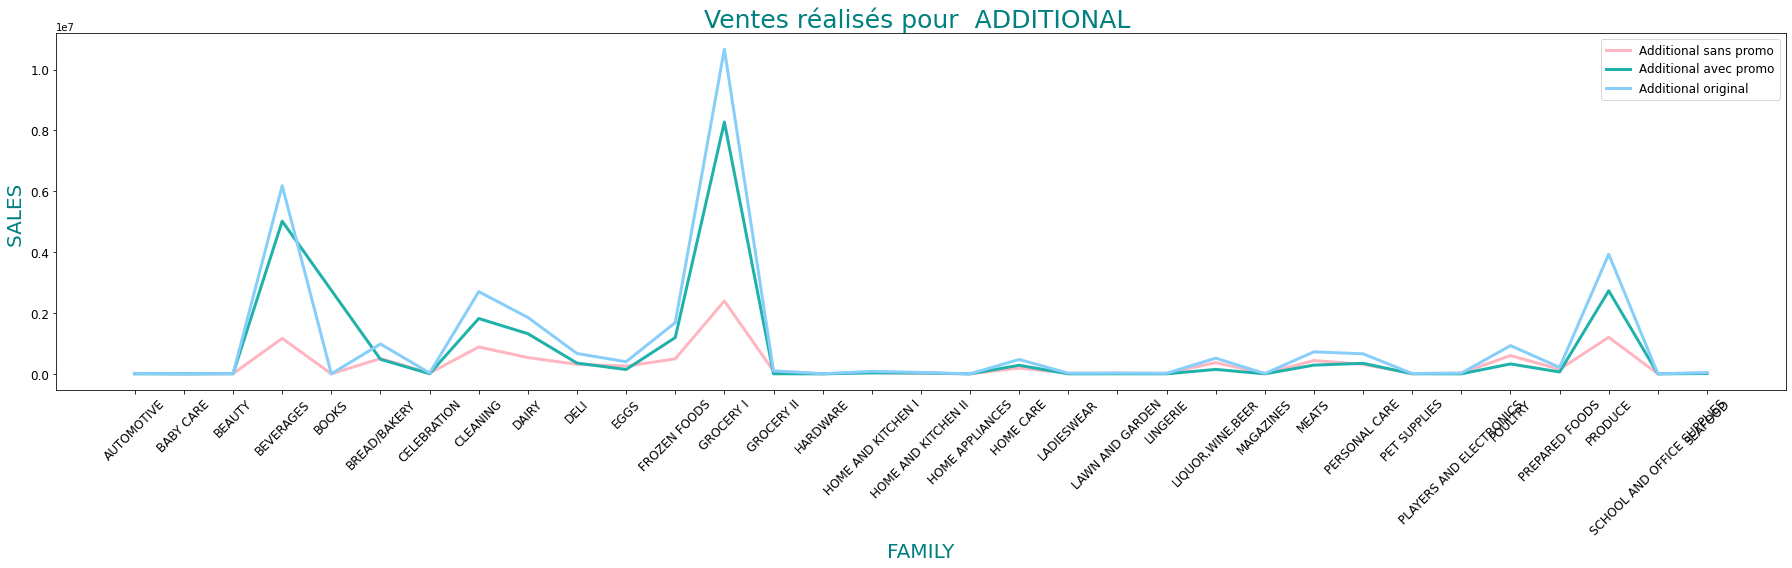

In [35]:
# Type = Additional

type_Additional_origine = type_hoday.loc[type_hoday["type"] == "Additional"]
type_Additional_original_gr = type_Additional_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
type_Additional = type_Additional_origine.loc[(type_Additional_origine["type"] == "Additional") & (type_Additional_origine["onpromotion"] == 0)]
type_Additional_0_gr = type_Additional.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
type_Additional_on = type_Additional_origine.loc[(type_Additional_origine["type"] == "Additional") & (type_Additional_origine["onpromotion"] != 0)]
type_Additional_1_gr = type_Additional_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))
# Additional
plt.plot(type_Additional_0_gr["family"],type_Additional_0_gr["sales"], color = 'lightpink', label = "Additional sans promo", lw = 3)
plt.plot(type_Additional_1_gr["family"],type_Additional_1_gr["sales"], color = 'lightseagreen', label = "Additional avec promo", lw =3)
plt.plot(type_Additional_original_gr["family"],type_Additional_original_gr["sales"], color = 'lightskyblue', label = "Additional original", lw =3)

# Métadonnées 
plt.title( "Ventes réalisés pour  ADDITIONAL ", fontsize = 25, color = "teal")
plt.ylabel("SALES ", fontsize = 20, color = "teal")
plt.xlabel("FAMILY", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend(fontsize = 12)

print("Vente totale Additional:", round(type_Additional_origine.sales.sum()))

print("ventes sans promo:", round(type_Additional_0_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_Additional_0_gr['sales'].sum()/type_Additional_origine.sales.sum()))

print("ventes avec promo:", round(type_Additional_1_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_Additional_1_gr['sales'].sum()/type_Additional_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_Additional_on)/len(type_Additional_origine)))

#### Transfer

Vente totale Transfer: 7501824
ventes sans promo: 889716 ; Ce qui représente un pourcentage de:  12
ventes avec promo: 6612108 ; Ce qui représente un pourcentage de:  88
La proportion des ventes avec promotion est de:  39


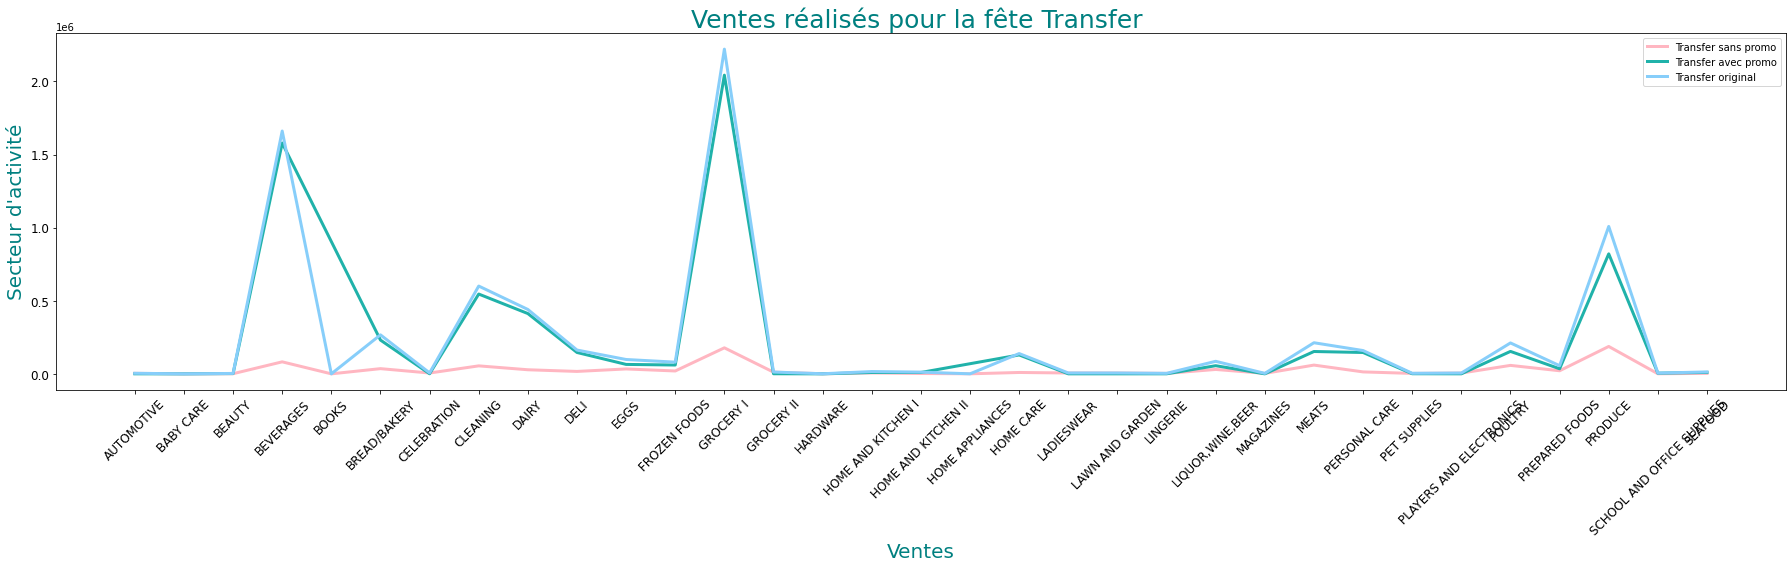

In [36]:
# Type = Transfer

type_Transfer_origine = type_hoday.loc[type_hoday["type"] == "Transfer"]
type_Transfer_original_gr = type_Transfer_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
type_Transfer = type_Transfer_origine.loc[(type_Transfer_origine["type"] == "Transfer") & (type_Transfer_origine["onpromotion"] == 0)]
type_Transfer_0_gr = type_Transfer.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
type_Transfer_on = type_Transfer_origine.loc[(type_Transfer_origine["type"] == "Transfer") & (type_Transfer_origine["onpromotion"] != 0)]
type_Transfer_1_gr = type_Transfer_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))
# Transfer
plt.plot(type_Transfer_0_gr["family"],type_Transfer_0_gr["sales"], color = 'lightpink', label = "Transfer sans promo", lw = 3)
plt.plot(type_Transfer_1_gr["family"],type_Transfer_1_gr["sales"], color = 'lightseagreen', label = "Transfer avec promo", lw =3)
plt.plot(type_Transfer_original_gr["family"],type_Transfer_original_gr["sales"], color = 'lightskyblue', label = "Transfer original", lw =3)

# Métadonnées 
plt.title( "Ventes réalisés pour la fête Transfer ", fontsize = 25, color = "teal")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend()

print("Vente totale Transfer:", round(type_Transfer_origine.sales.sum()))

print("ventes sans promo:", round(type_Transfer_0_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_Transfer_0_gr['sales'].sum()/type_Transfer_origine.sales.sum()))

print("ventes avec promo:", round(type_Transfer_1_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_Transfer_1_gr['sales'].sum()/type_Transfer_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_Transfer_on)/len(type_Transfer_origine)))

#### Bridge

Vente totale Bridge: 2388330
ventes sans promo: 325024 ; Ce qui représente un pourcentage de:  14
ventes avec promo: 2063306 ; Ce qui représente un pourcentage de:  86
La proportion des ventes avec promotion est de:  33


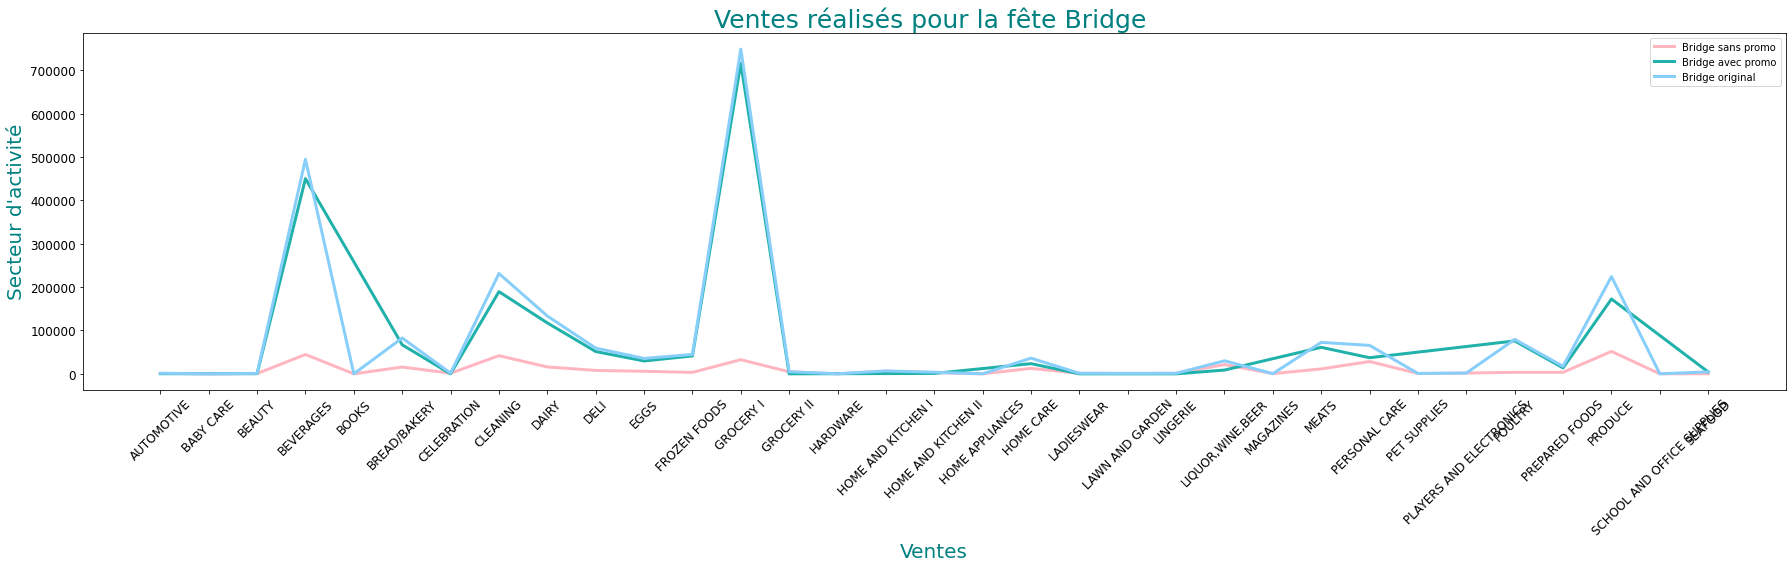

In [37]:
# Type = Bridge
# Bridge original
type_Bridge_origine = type_hoday.loc[type_hoday["type"] == "Bridge"]
type_Bridge_original_gr = type_Bridge_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
type_Bridge = type_Bridge_origine.loc[(type_Bridge_origine["type"] == "Bridge") & (type_Bridge_origine["onpromotion"] == 0)]
type_Bridge_0_gr = type_Bridge.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
type_Bridge_on = type_Bridge_origine.loc[(type_Bridge_origine["type"] == "Bridge") & (type_Bridge_origine["onpromotion"] != 0)]
type_Bridge_1_gr = type_Bridge_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))
# Holiday
plt.plot(type_Bridge_0_gr["family"],type_Bridge_0_gr["sales"], color = 'lightpink', label = "Bridge sans promo", lw = 3)
plt.plot(type_Bridge_1_gr["family"],type_Bridge_1_gr["sales"], color = 'lightseagreen', label = "Bridge avec promo", lw =3)
plt.plot(type_Bridge_original_gr["family"],type_Bridge_original_gr["sales"], color = 'lightskyblue', label = "Bridge original", lw =3)

# Métadonnées 
plt.title( "Ventes réalisés pour la fête Bridge ", fontsize = 25, color = "teal")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend()

print("Vente totale Bridge:", round(type_Bridge_origine.sales.sum()))

print("ventes sans promo:", round(type_Bridge_0_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_Bridge_0_gr['sales'].sum()/type_Bridge_origine.sales.sum()))

print("ventes avec promo:", round(type_Bridge_1_gr['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_Bridge_1_gr['sales'].sum()/type_Bridge_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_Bridge_on)/len(type_Bridge_origine)))

#### Work_day

Vente totale Work_day: 3315924
ventes sans promo: 1179415 ; Ce qui représente un pourcentage de:  36
ventes avec promo: 2136509 ; Ce qui représente un pourcentage de:  64
La proportion des ventes avec promotion est de:  18


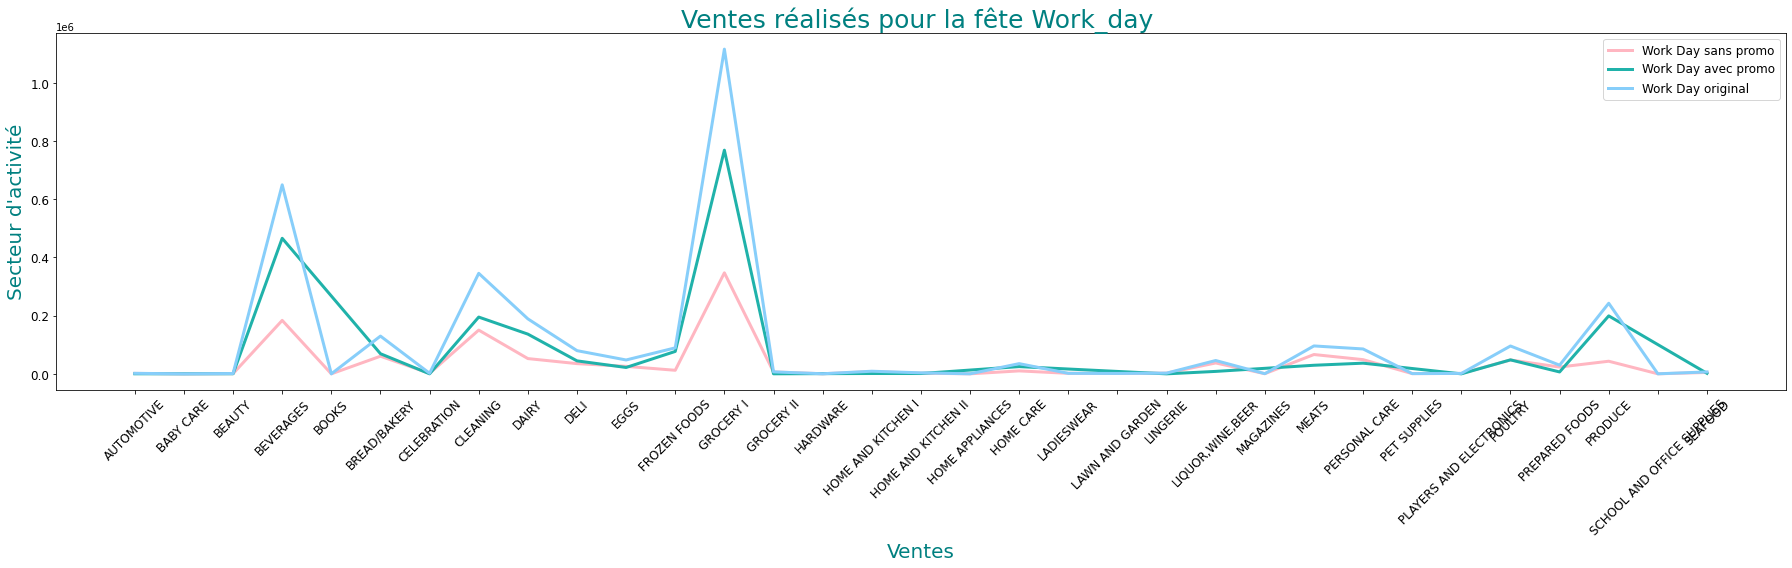

In [38]:
# Type = Work_day
# Work_day original
type_Work_day_origine = type_hoday.loc[type_hoday["type"] == "Work Day"]
type_Work_day_original_gr = type_Work_day_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
type_Work_day = type_Work_day_origine.loc[(type_Work_day_origine["type"] == "Work Day") & (type_Work_day_origine["onpromotion"] == 0)]
type_Work_day_0_gr = type_Work_day.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
type_Work_day_on = type_Work_day_origine.loc[(type_Work_day_origine["type"] == "Work Day") & (type_Work_day_origine["onpromotion"] != 0)]
type_Work_day_1_gr = type_Work_day_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))
# Work day
plt.plot(type_Work_day_0_gr["family"],type_Work_day_0_gr["sales"], color = 'lightpink', label = "Work Day sans promo", lw = 3)
plt.plot(type_Work_day_1_gr["family"],type_Work_day_1_gr["sales"], color = 'lightseagreen', label = "Work Day avec promo", lw =3)
plt.plot(type_Work_day_original_gr["family"],type_Work_day_original_gr["sales"], color = 'lightskyblue', label = "Work Day original", lw =3)

# Métadonnées 
plt.title( "Ventes réalisés pour la fête Work_day ", fontsize = 25, color = "teal")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend(fontsize = 12)

print("Vente totale Work_day:", round(type_Work_day_origine.sales.sum()))

print("ventes sans promo:", round(type_Work_day['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*type_Work_day['sales'].sum()/type_Work_day_origine.sales.sum()))

print("ventes avec promo:", round(type_Work_day_on['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*type_Work_day_on['sales'].sum()/type_Work_day_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(type_Work_day_on)/len(type_Work_day_origine)))

#### Comparaison des ventes pour chaque type d'évènement

In [39]:
type_hoday_type= train_hoday[["sales","type"]]
type_hoday_type_gr = type_hoday_type.groupby(by = "type").agg({"sales": "sum"}).reset_index()
type_hoday_type_gr

type         sales
0  Additional  3.302028e+07
1      Bridge  2.388330e+06
2       Event  4.247747e+07
3     Holiday  1.092227e+08
4    Transfer  7.501824e+06
5    Work Day  3.315924e+06

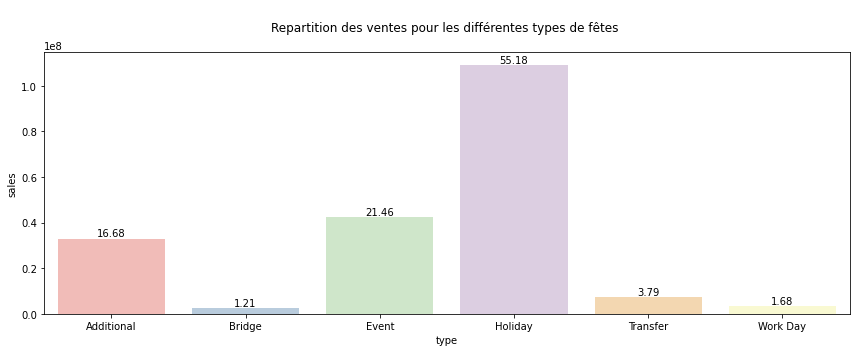

In [40]:
# Plot
#Pourcentage des ventes pour les différentes types de fêtes  
fig, ax = plt.subplots(figsize = (12,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "type",  data = type_hoday_type_gr, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nRepartition des ventes pour les différentes types de fêtes \n", fontsize = 12)



#ax= sns.barplot( x.family ,x.sales, alpha=0.8,  palette="Spectral")
# annotation here


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/type_hoday_type_gr["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()

### Analyse des ventes de la colonne "locale" (fêtes locales, Régionales et Nationales)

In [41]:
local_hoday = train_hoday[["family","sales", "locale", "onpromotion"]]
local_hoday.head(2)

family  sales    locale  onpromotion
0  AUTOMOTIVE    0.0  National            0
1   BABY CARE    0.0  National            0

#### Fête Nationale

Vente totale National: 109169610
ventes sans promo: 29204817 ; Ce qui représente un pourcentage de:  27
ventes avec promo: 79964792 ; Ce qui représente un pourcentage de:  73
La proportion des ventes avec promotion est de:  24


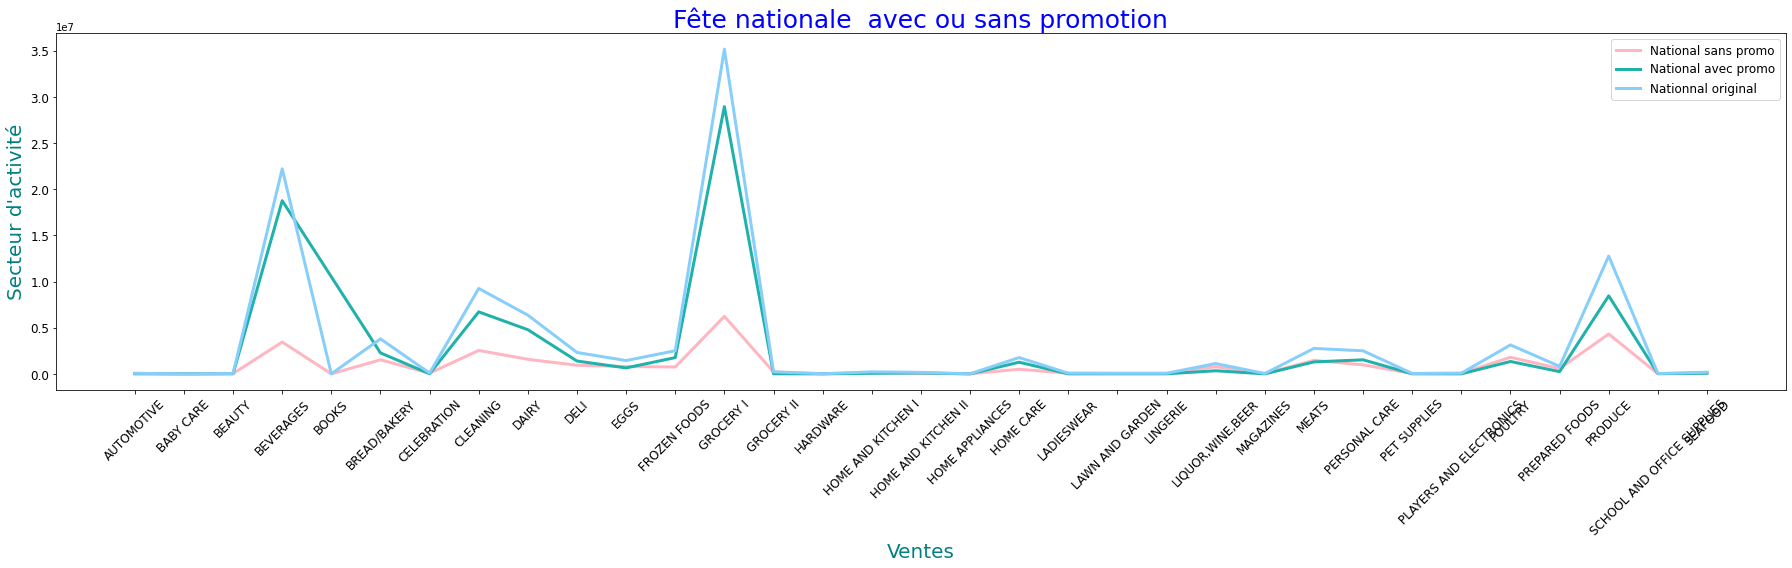

In [42]:
# Local = National

national_origine = local_hoday.loc[local_hoday["locale"] == "National"]
national_original_gr = national_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
national_0 = national_origine.loc[(national_origine["locale"] == "National") & (national_origine["onpromotion"] == 0)]
national_0_gr = national_0.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
national_on = national_origine.loc[(national_origine["locale"] == "National") & (national_origine["onpromotion"] != 0)]
national_1_gr = national_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))

# National
plt.plot(national_0_gr["family"],national_0_gr["sales"], color = "lightpink", label = "National sans promo", lw = 3)
plt.plot(national_1_gr["family"],national_1_gr["sales"], color = 'lightseagreen', label = "National avec promo", lw =3)
plt.plot(national_original_gr["family"],national_original_gr["sales"], color = 'lightskyblue', label = "Nationnal original", lw =3)

# Métadonnées 
plt.title( "Fête nationale  avec ou sans promotion", fontsize = 25, color = "blue")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend(fontsize = (12))



print("Vente totale National:", round(national_origine.sales.sum()))

print("ventes sans promo:", round(national_0['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*national_0['sales'].sum()/national_origine.sales.sum()))

print("ventes avec promo:", round(national_on['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*national_on['sales'].sum()/national_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(national_on)/len(national_origine)))

Vente totale local: 76343288
ventes sans promo: 24216203 ; Ce qui représente un pourcentage de:  32
ventes avec promo: 52127085 ; Ce qui représente un pourcentage de:  68
La proportion des ventes avec promotion est de:  22


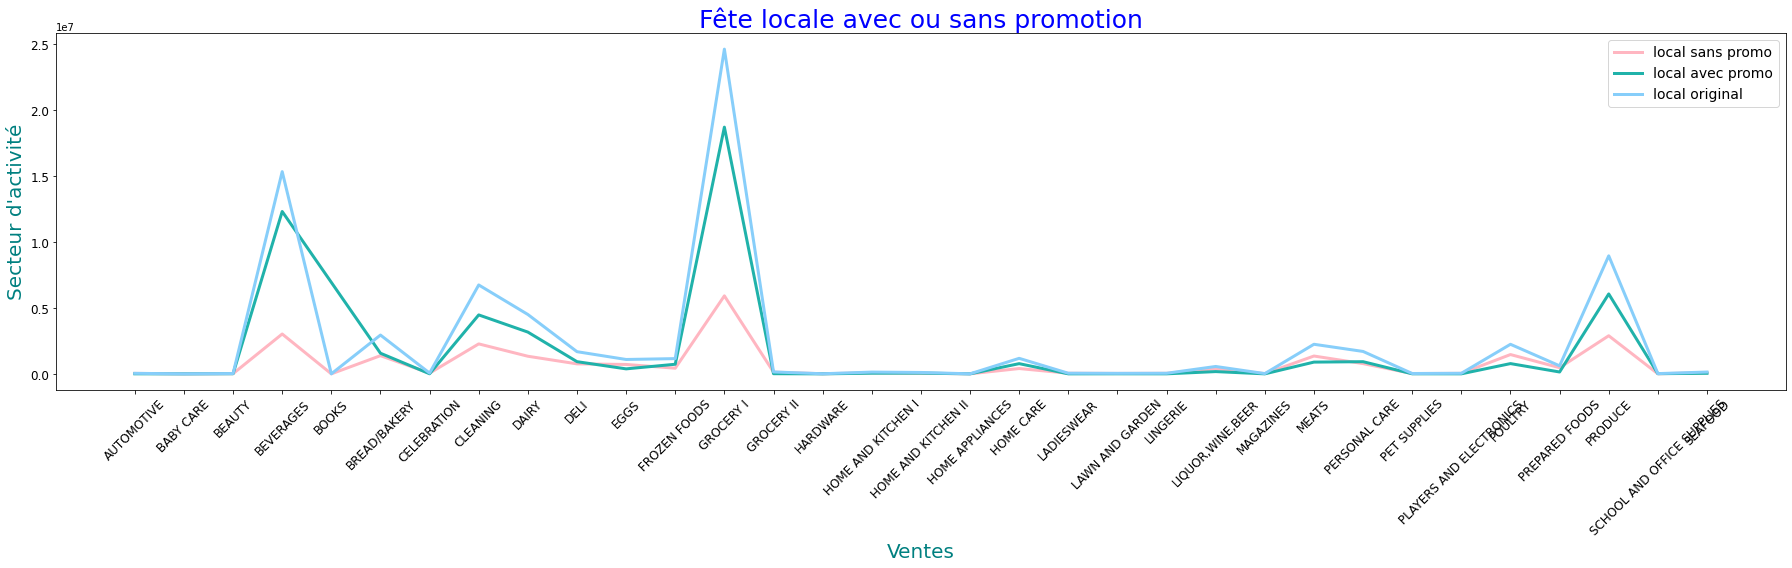

In [43]:
# Local = local

local_origine = local_hoday.loc[local_hoday["locale"] == "Local"]
local_original_gr = local_origine.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Pas de promotion
local_0 = local_origine.loc[(local_origine["locale"] == "Local") & (local_origine["onpromotion"] == 0)]
local_0_gr = local_0.groupby(by="family").agg({"sales" : "sum"}).reset_index()

# Avec des promotion
local_on = local_origine.loc[(local_origine["locale"] == "Local") & (local_origine["onpromotion"] != 0)]
local_1_gr = local_on.groupby(by="family").agg({"sales" : "sum"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))

# local
plt.plot(local_0_gr["family"],local_0_gr["sales"], color = "lightpink", label = "local sans promo", lw = 3)
plt.plot(local_1_gr["family"],local_1_gr["sales"], color = 'lightseagreen', label = "local avec promo", lw =3)
plt.plot(local_original_gr["family"],local_original_gr["sales"], color = 'lightskyblue', label = "local original", lw =3)

# Métadonnées 
plt.title( "Fête locale avec ou sans promotion", fontsize = 25, color = "blue")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend(fontsize = 14)

print("Vente totale local:", round(local_origine.sales.sum()))

print("ventes sans promo:", round(local_0['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*local_0['sales'].sum()/local_origine.sales.sum()))

print("ventes avec promo:", round(local_on['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*local_on['sales'].sum()/local_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(local_on)/len(local_origine)))

#### Fêtes regional

Vente totale regional: 12413598
ventes sans promo: 4102330 ; Ce qui représente un pourcentage de:  33
ventes avec promo: 8311268 ; Ce qui représente un pourcentage de:  67
La proportion des ventes avec promotion est de:  20


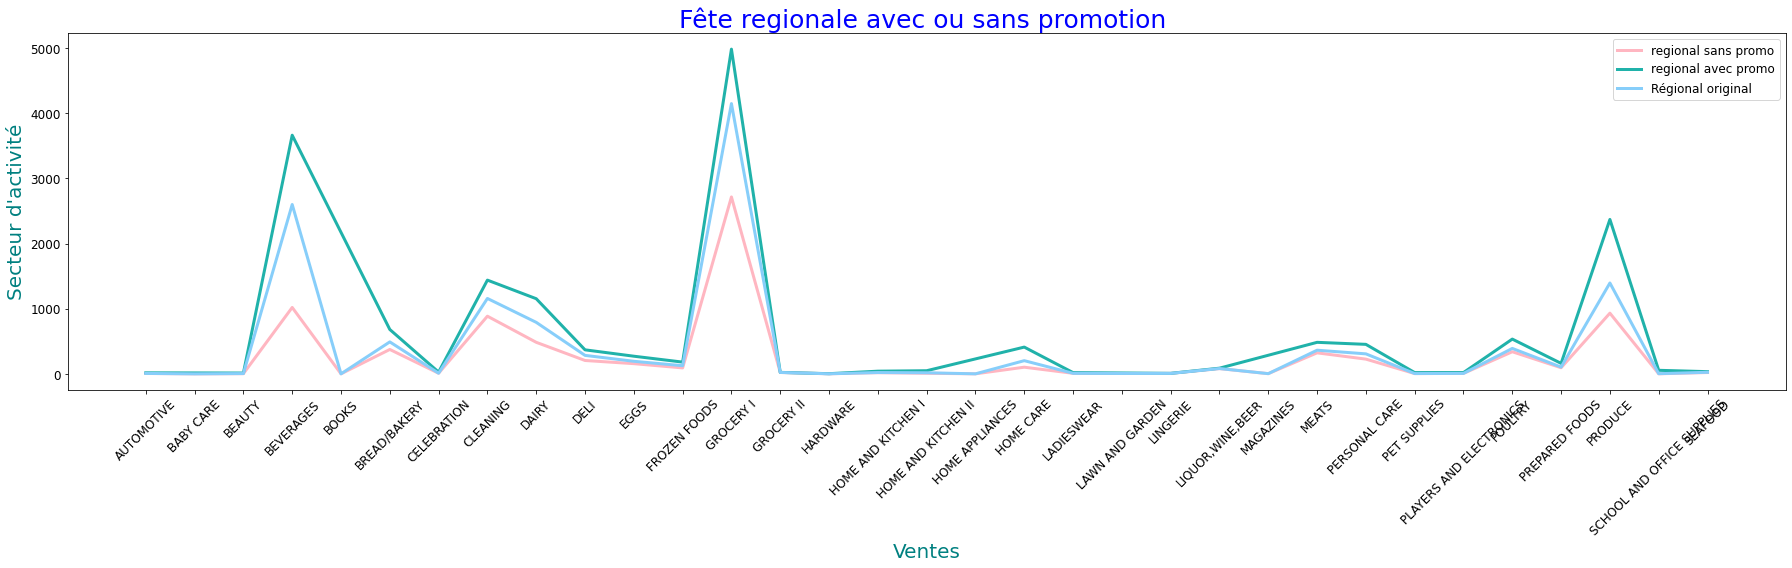

In [44]:
# regional = regional

regional_origine = local_hoday.loc[local_hoday["locale"] == "Regional"]
regional_original_gr = regional_origine.groupby(by="family").agg({"sales" : "mean"}).reset_index()

# Pas de promotion
regional_0 = regional_origine.loc[(regional_origine["locale"] == "Regional") & (regional_origine["onpromotion"] == 0)]
regional_0_gr = regional_0.groupby(by="family").agg({"sales" : "mean"}).reset_index()

# Avec des promotion
regional_on = regional_origine.loc[(regional_origine["locale"] == "Regional") & (regional_origine["onpromotion"] != 0)]
regional_1_gr = regional_on.groupby(by="family").agg({"sales" : "mean"}).reset_index()


# Pametres requis 
plt.figure(figsize = (25,8))

# regional
plt.plot(regional_0_gr["family"],regional_0_gr["sales"], color = "lightpink", label = "regional sans promo", lw = 3)
plt.plot(regional_1_gr["family"],regional_1_gr["sales"], color = 'lightseagreen', label = "regional avec promo", lw =3)
plt.plot(regional_original_gr["family"],regional_original_gr["sales"], color = 'lightskyblue', label = "Régional original", lw =3)

# Métadonnées 
plt.title( "Fête regionale avec ou sans promotion ", fontsize = 25, color = "blue")
plt.ylabel("Secteur d'activité", fontsize = 20, color = "teal")
plt.xlabel("Ventes", fontsize = 20, color = "teal")
plt.yticks (fontsize = 12)
plt.xticks(fontsize = 12, rotation = 45)
plt.tight_layout()
plt.legend(fontsize = 12)


print("Vente totale regional:", round(regional_origine.sales.sum()))

print("ventes sans promo:", round(regional_0['sales'].sum()), "; Ce qui représente un pourcentage de: ",
                            round(100*regional_0['sales'].sum()/regional_origine.sales.sum()))

print("ventes avec promo:", round(regional_on['sales'].sum()), "; Ce qui représente un pourcentage de: ", 
                            round(100*regional_on['sales'].sum()/regional_origine.sales.sum()))

print("La proportion des ventes avec promotion est de: ", round(100 *len(regional_on)/len(regional_origine)))

#### comparaison des ventes pour les différentes fêtes

In [45]:
local_hoday = train_hoday[["family", "sales","locale"]]
local_hoday_gr = local_hoday.groupby("locale").agg({"sales" : "sum"}).reset_index()
local_hoday_gr

locale         sales
0     Local  7.634329e+07
1  National  1.091696e+08
2  Regional  1.241360e+07

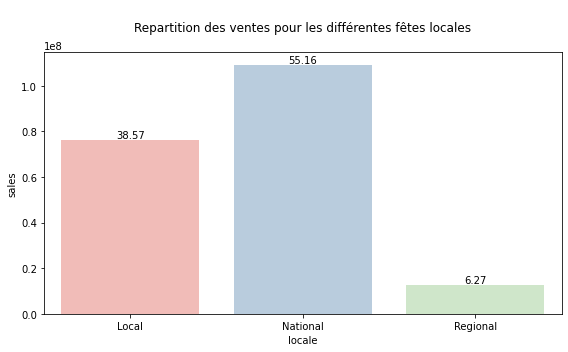

In [46]:
# Plot
#Pourcentage des ventes pour les différentes fêtes locales 
fig, ax = plt.subplots(figsize = (8,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "locale",  data = local_hoday_gr, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nRepartition des ventes pour les différentes fêtes locales\n", fontsize = 12)



#ax= sns.barplot( x.family ,x.sales, alpha=0.8,  palette="Spectral")
# annotation here


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/local_hoday_gr["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()

In [47]:
train_hoday.head()

id       date  store_nbr      family  sales  onpromotion     type  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1 2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2 2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4 2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description  ...   city      state type_store  \
0  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
1  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
2  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
3  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   
4  National     Ecuador  Primer dia del ano  ...  Quito  Pichincha          D   

  cluster  weekend  weekday  Year  Month  day  quarter  
0      13        0        1  2013      1    1   2013Q1  
1      13        0        1  2013      1    1   2013Q1  
2      13        0        1  2013      1    1   2013Q1  
3      13        0        1  2013      1    1   2013Q1  
4      13        0        1  2013      1    1   2013Q1  

[5 rows x 21 columns]

In [48]:
train_hoday_description = pd.read_csv(r"C:\Users\Utilisateur\projet 8\holidays_events.csv", index_col = 'date', parse_dates = ['date'])
train_hoday_description = train_hoday_description.sort_index()
pd.set_option('display.max_rows', 352)
train_hoday_description

type    locale                     locale_name  \
date                                                               
2012-03-02     Holiday     Local                           Manta   
2012-04-01     Holiday  Regional                        Cotopaxi   
2012-04-12     Holiday     Local                          Cuenca   
2012-04-14     Holiday     Local                        Libertad   
2012-04-21     Holiday     Local                        Riobamba   
2012-05-12     Holiday     Local                            Puyo   
2012-06-23     Holiday     Local                        Guaranda   
2012-06-25     Holiday  Regional                        Imbabura   
2012-06-25     Holiday     Local                       Latacunga   
2012-06-25     Holiday     Local                         Machala   
2012-07-03     Holiday     Local                   Santo Domingo   
2012-07-03     Holiday     Local                       El Carmen   
2012-07-23     Holiday     Local                         Cayambe   
2012-08-05     Holiday     Local                      Esmeraldas   
2012-08-10     Holiday  National                         Ecuador   
2012-08-15     Holiday     Local                        Riobamba   
2012-08-24     Holiday     Local                          Ambato   
2012-09-28     Holiday     Local                          Ibarra   
2012-10-07     Holiday     Local                         Quevedo   
2012-10-09     Holiday  National                         Ecuador   
2012-10-12    Transfer  National                         Ecuador   
2012-11-02     Holiday  National                         Ecuador   
2012-11-03     Holiday  National                         Ecuador   
2012-11-06     Holiday  Regional  Santo Domingo de los Tsachilas   
2012-11-07     Holiday  Regional                     Santa Elena   
2012-11-10     Holiday     Local                        Guaranda   
2012-11-11     Holiday     Local                       Latacunga   
2012-11-12     Holiday     Local                          Ambato   
2012-12-05  Additional     Local                           Quito   
2012-12-06     Holiday     Local                           Quito   
2012-12-08     Holiday     Local                            Loja   
2012-12-21  Additional  National                         Ecuador   
2012-12-22     Holiday     Local                         Salinas   
2012-12-22  Additional  National                         Ecuador   
2012-12-23  Additional  National                         Ecuador   
2012-12-24      Bridge  National                         Ecuador   
2012-12-24  Additional  National                         Ecuador   
2012-12-25     Holiday  National                         Ecuador   
2012-12-26  Additional  National                         Ecuador   
2012-12-31      Bridge  National                         Ecuador   
2012-12-31  Additional  National                         Ecuador   
2013-01-01     Holiday  National                         Ecuador   
2013-01-05    Work Day  National                         Ecuador   
2013-01-12    Work Day  National                         Ecuador   
2013-02-11     Holiday  National                         Ecuador   
2013-02-12     Holiday  National                         Ecuador   
2013-03-02     Holiday     Local                           Manta   
2013-04-01     Holiday  Regional                        Cotopaxi   
2013-04-12     Holiday     Local                          Cuenca   
2013-04-14     Holiday     Local                        Libertad   
2013-04-21     Holiday     Local                        Riobamba   
2013-04-29     Holiday  National                         Ecuador   
2013-05-01     Holiday  National                         Ecuador   
2013-05-11  Additional  National                         Ecuador   
2013-05-12     Holiday     Local                            Puyo   
2013-05-12       Event  National                         Ecuador   
2013-05-24     Holiday  National                         Ecuador   
2013-0

### Comparer les ventes par date

#### Analyse des ventes par an

In [49]:
#Analyse des ventes par année 
train_hoyear = train_hoday.groupby(by = ["Year"]).agg({"sales" : "sum"}).reset_index()
#train_hoyear

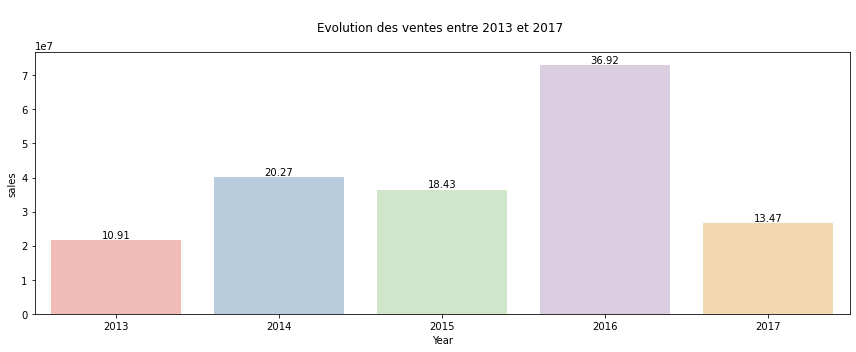

In [50]:
# Plot
#Pourcentage des ventes pour les différentes différentes années
fig, ax = plt.subplots(figsize = (12,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "Year",  data = train_hoyear, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes entre 2013 et 2017 \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_hoyear["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()

In [51]:
train_hoday_date = train_hoday.groupby(by = "date").agg({"sales":"mean"})
#train_hoday_date

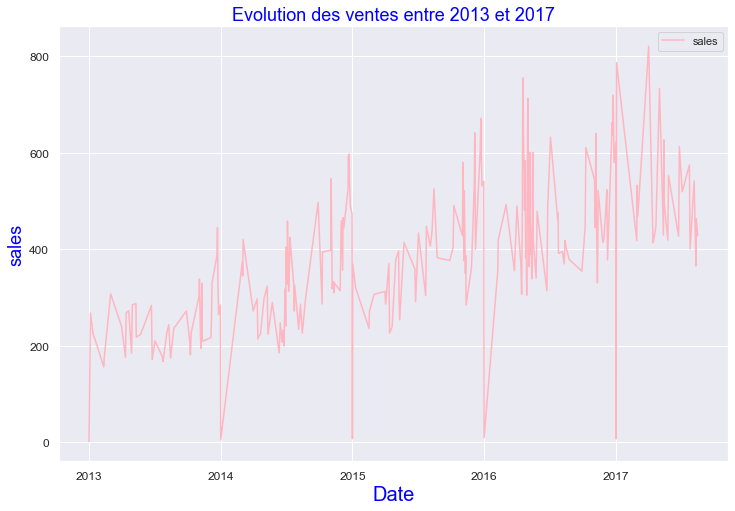

In [52]:
# Evolution des ventes par mois 
sns.set(style = "darkgrid")
plt.figure(figsize = (12,8))

# Variables de la figure

x = train_hoday_date.index
y = train_hoday_date["sales"]


plt.plot(x, y, color = "lightpink", label = "sales")

# Métadonnées
plt.title("Evolution des ventes entre 2013 et 2017", fontsize = 18, color = "blue")
plt.ylabel("sales", fontsize = 18, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Sauvegarder la figure 



plt.legend()

In [53]:
train_hoyear_family = train_hoday[["date", "store_nbr", "sales"]]
train_hoyear_family = train_hoyear_family.set_index("date")
#train_hoyear_family

In [54]:
#create a dic that contain each store total daily sale.
family_sale_dict = {}
for i in train_hoyear_family.store_nbr.unique():
    daily_sale = train_hoyear_family[train_hoyear_family['store_nbr']==i]
    family_sale_dict[i] = daily_sale

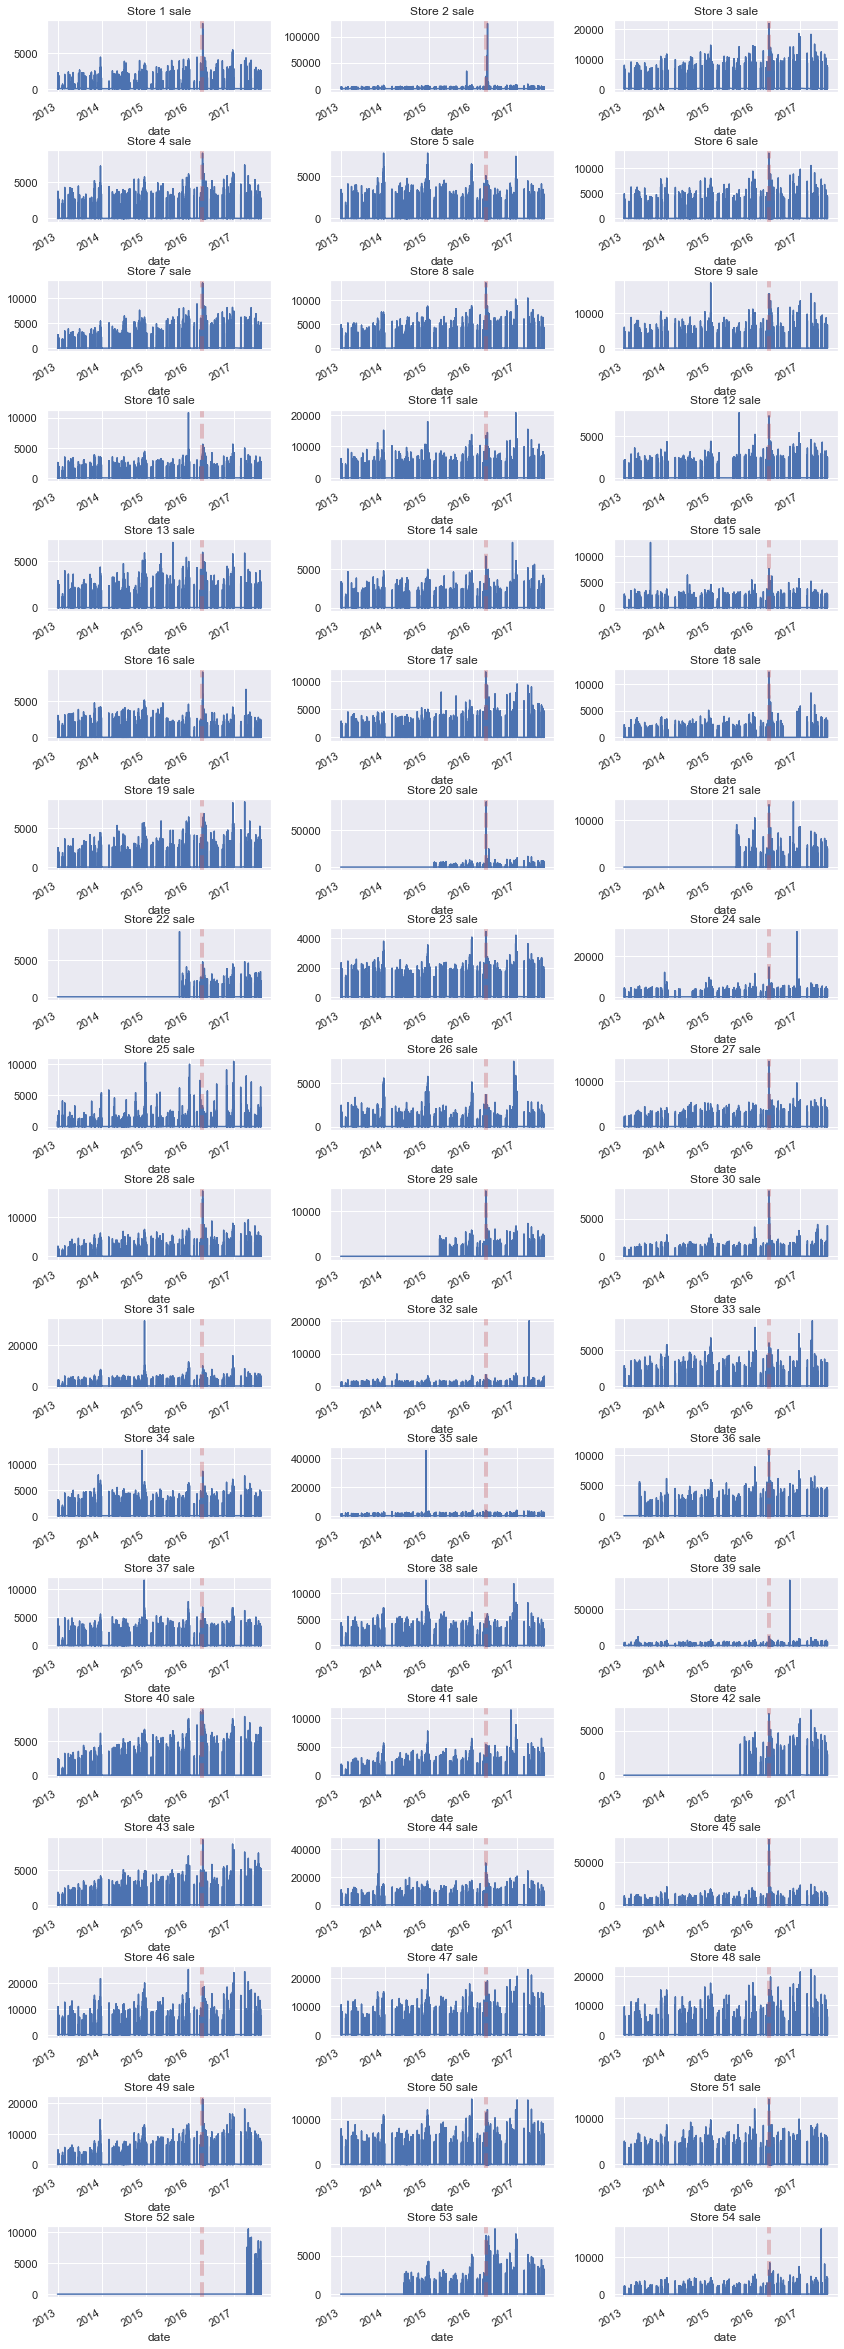

In [55]:
fig = plt.figure(figsize=(12,40))
for i in family_sale_dict.keys():
    plt.subplot(18,3,i)
    plt.title('Store {} sale'.format(i))
    plt.tight_layout()
    sale = family_sale_dict[i].sales
    sale.plot()
    plt.axvline(x=pd.Timestamp('2016-04-16'),color='r',linestyle='--',linewidth=4,alpha=0.3) #mark the earthquake
    
plt.savefig("ventes_magasin.png")

#### Analyse des ventes par mois

In [56]:
train_homonth = train_hoday.groupby(by = ["Month"]).agg({"sales" : "sum"}).reset_index()
train_homonth["Month"] = ['01_Jan','02_Feb','03_Mar','04_Apr','05_May','06_Jun','07_Jul','08_Aug','09_Sep','10_Oct','11_Nov','12_Dec']
#train_homonth

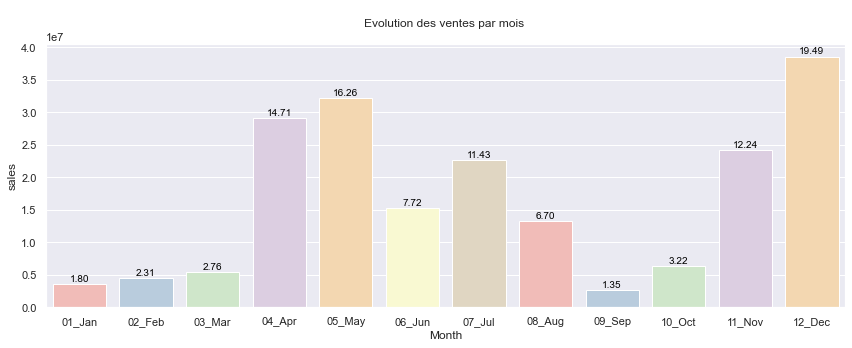

In [57]:
#Analyse des ventes par mois


#Pourcentage des ventes pour les différentes différentes années
fig, ax = plt.subplots(figsize = (12,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "Month",  data = train_homonth, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes par mois \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_homonth["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()



#### Analyse des ventes par jour

In [58]:
#Analyse des ventes par jour

train_hoday_days = train_hoday.groupby(by = ["weekday"]).agg({"sales" : "sum"}).reset_index()
train_hoday_days["day"] =(['01-Monday ','02-Tuesday ','03-Wednesday','04-Thursday','05-Friday','06-Saturday','07-Sunday'])

train_hoday_days

weekday         sales           day
0        0  3.273947e+07    01-Monday 
1        1  2.394072e+07   02-Tuesday 
2        2  2.093095e+07  03-Wednesday
3        3  2.212683e+07   04-Thursday
4        4  3.115303e+07     05-Friday
5        5  3.302422e+07   06-Saturday
6        6  3.401127e+07     07-Sunday

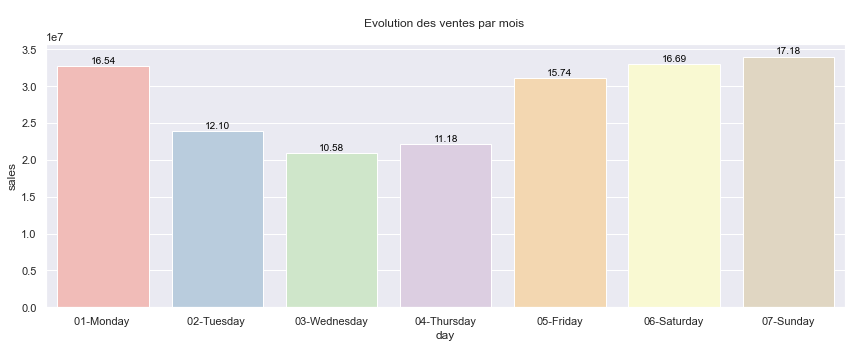

In [59]:

#Pourcentage des ventes par jour 
fig, ax = plt.subplots(figsize = (12,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "day",  data = train_hoday_days, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes par mois \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_hoday_days["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()



#### Analyse des ventes par trimestre 

In [60]:
train_hoquarter = train_hoday.groupby(by = ["quarter"]).agg({"sales" : "sum"}).reset_index()



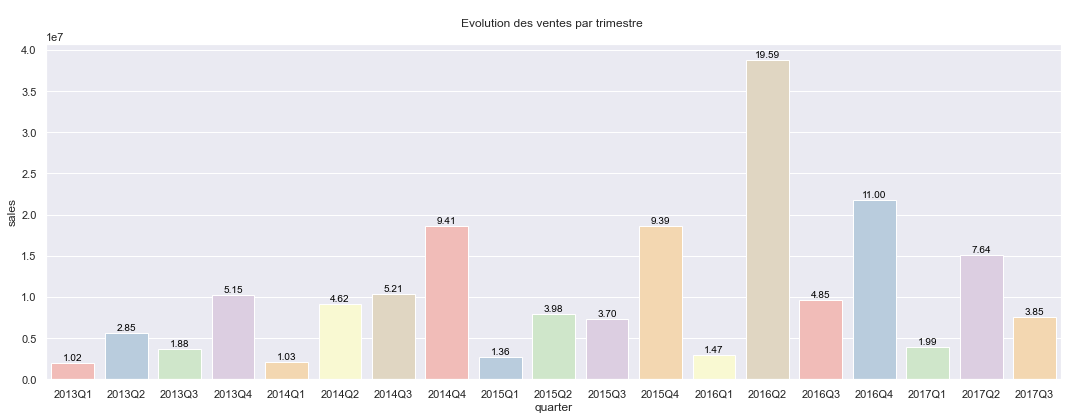

In [61]:

#Pourcentage des ventes pour les différentes différentes années
fig, ax = plt.subplots(figsize = (15,6))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "quarter",  data = train_hoquarter, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes par trimestre \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_hoquarter["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()



### Comportement des ventes les jours de paie 

In [62]:
train_hoday_day = train_hoday.groupby(by = ["Month","day","family"]).agg({"sales": "mean"}).reset_index()
train_hoday_day

Month  day                      family        sales
0         1    1                  AUTOMOTIVE     0.051852
1         1    1                   BABY CARE     0.007407
2         1    1                      BEAUTY     0.085185
3         1    1                   BEVERAGES    57.870370
4         1    1                       BOOKS     0.000000
...     ...  ...                         ...          ...
3592     12   31                     POULTRY   423.647084
3593     12   31              PREPARED FOODS   103.013278
3594     12   31                     PRODUCE  2404.603556
3595     12   31  SCHOOL AND OFFICE SUPPLIES     0.601852
3596     12   31                     SEAFOOD    17.534014

[3597 rows x 4 columns]

In [63]:
train_hoday_month = train_hoday.groupby(by = "day").agg({"sales": "sum"}).reset_index()
#train_hoday_month

In [64]:
train_hoday_month_family = train_hoday.groupby(by = ["family"]).agg({"sales": "sum"}).reset_index()
train_hoday_month_family["family_nbr"] = train_hoday_month_family["family"] 
# On va renommer la colonne family
train_hoday_month_family["family_nbr"] =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                           21,22,23,24,25,26,27,28,29,30,31,32,33]
train_hoday_month_family

family         sales  family_nbr
0                   AUTOMOTIVE  9.983000e+04           1
1                    BABY CARE  1.913000e+03           2
2                       BEAUTY  6.411700e+04           3
3                    BEVERAGES  4.003907e+07           4
4                        BOOKS  1.126000e+03           5
5                 BREAD/BAKERY  7.204969e+06           6
6                  CELEBRATION  1.481610e+05           7
7                     CLEANING  1.710662e+07           8
8                        DAIRY  1.162279e+07           9
9                         DELI  4.269881e+06          10
10                        EGGS  2.713001e+06          11
11                FROZEN FOODS  3.781350e+06          12
12                   GROCERY I  6.378889e+07          13
13                  GROCERY II  3.808540e+05          14
14                    HARDWARE  1.843500e+04          15
15          HOME AND KITCHEN I  3.679620e+05          16
16         HOME AND KITCHEN II  2.803080e+05          17
17             HOME APPLIANCES  7.224000e+03          18
18                   HOME CARE  3.134357e+06          19
19                  LADIESWEAR  1.261520e+05          20
20             LAWN AND GARDEN  1.044530e+05          21
21                    LINGERIE  1.117750e+05          22
22            LIQUOR,WINE,BEER  1.753652e+06          23
23                   MAGAZINES  5.745800e+04          24
24                       MEATS  5.346598e+06          25
25               PERSONAL CARE  4.491270e+06          26
26                PET SUPPLIES  6.992100e+04          27
27     PLAYERS AND ELECTRONICS  1.179950e+05          28
28                     POULTRY  5.750102e+06          29
29              PREPARED FOODS  1.519761e+06          30
30                     PRODUCE  2.305484e+07          31
31  SCHOOL AND OFFICE SUPPLIES  5.256000e+04          32
32                     SEAFOOD  3.390984e+05          33

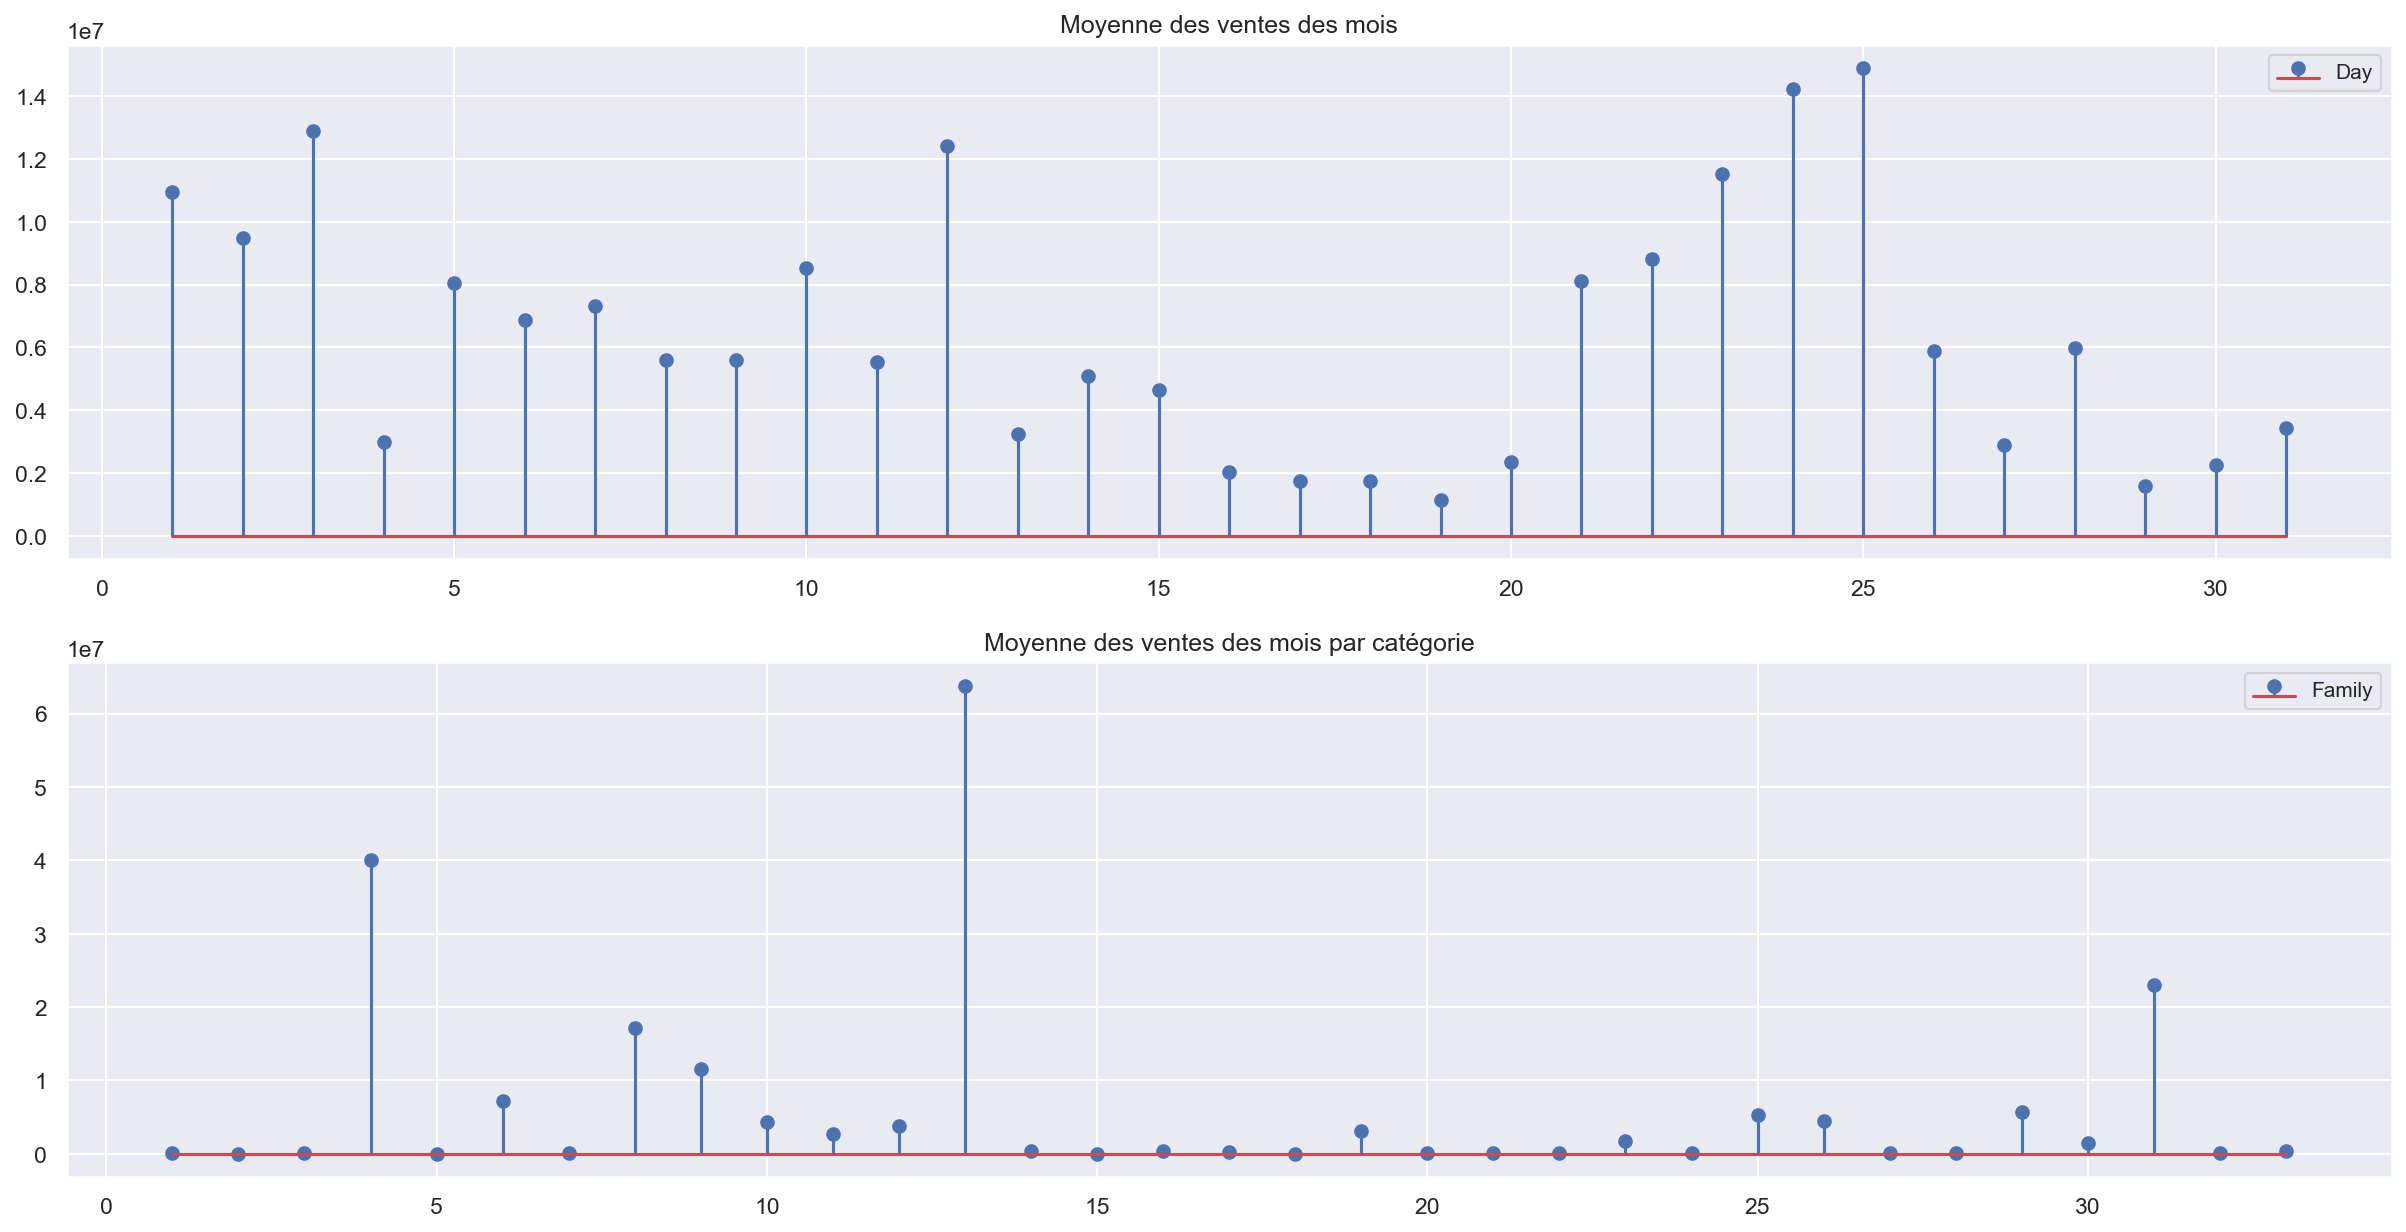

In [65]:
# Plot
#Ventes réalisées par mois 
fig, axes = plt.subplots(2, 1, figsize=(20,10), dpi=150)
#fig.suptitle("ventes réalisées par mois", color="blue",  fontsize=15)

# Graphique du mois de Janvier
x = train_hoday_month["day"]
y =  train_hoday_month["sales"] 
axes[0].stem(x,y , data = train_hoday_month, use_line_collection = True, label= "Day")
axes[0].set_title("Moyenne des ventes des mois", fontsize = 12)
axes[0].legend(loc='upper right', fontsize=10)

x = train_hoday_month_family["family_nbr"]
y =  train_hoday_month_family["sales"] 
axes[1].stem(x,y , data = train_hoday_month_family, use_line_collection = True, label= "Family")
axes[1].set_title("Moyenne des ventes des mois par catégorie", fontsize = 12)
axes[1].legend(loc='upper right', fontsize=10)


### Ventes Réalisées pour chaque magasin

In [66]:
train_hoday_store_nbr = train_hoday[["store_nbr","family", "sales"]]
train_hoday_store_gr1 =  train_hoday_store_nbr.groupby(by = ["store_nbr"]).agg({"sales": "sum"}).reset_index()
train_hoday_store_gr1.head(2)

store_nbr         sales
0          1  2.312469e+06
1          2  4.137665e+06

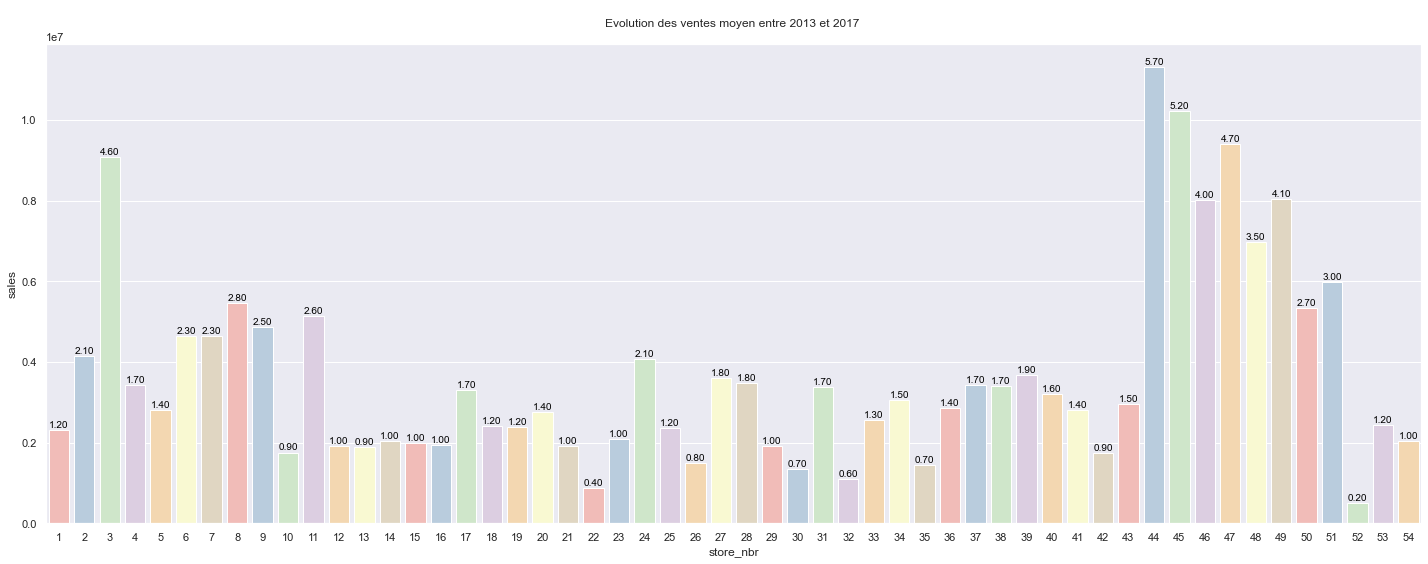

In [67]:
# Plot
#Pourcentage des ventes pour les différentes différentes années
fig, ax = plt.subplots(figsize = (20,8))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "store_nbr",  data = train_hoday_store_gr1, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes moyen entre 2013 et 2017 \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_hoday_store_nbr["sales"].sum(),1), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()

#### Analyse des 50 meilleurs numéros de  magasins entre 2013 et 2017

Nous allons de même regarder ce qui se passe pour ces magasins au cours de chaque année

In [68]:
store_an = train_hoday.groupby(by = ["store_nbr", "family", "Year"]).sum().reset_index().nlargest(50, "sales")
store_an = store_an.rename(columns = {"store_nbr": "store"})
store_an.head(2)

store     family  Year         id      sales  onpromotion  cluster  \
7323     45  GROCERY I  2016  194061513  1153961.0         6334      935   
7158     44  GROCERY I  2016  194058708  1049127.0         6384      425   

      weekend  weekday  Month   day  
7323       27      275    573  1271  
7158       27      275    573  1271

In [69]:
store_an['store'] = 'store ' + store_an.store.astype('str')
fig = px.bar(store_an, 
             x='store', 
             y='sales', 
             color='family',
             animation_frame='Year',
             title="Top 50 des ventes par catégorie et par an")
fig.show()

### clusters et store number

In [70]:
# Regargons comment se repartissent les clusters par rapport numéro de store.
hoday_store_cluster = train_hoday_store[["store_nbr", "cluster", "sales"]]
hoday_store_cluster_gr = hoday_store_cluster.groupby(by= "cluster" ).agg({"sales": "mean"}).reset_index()


In [71]:
# On va regarder le nombre de magasins contenus dans chaque cluster
cluster_store = hoday_store_cluster.groupby(by= "cluster" ).store_nbr.unique()
cluster_store

cluster
1                     [24, 25, 27]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [38, 41, 5]
5                             [44]
6          [11, 20, 21, 34, 39, 9]
7                         [14, 22]
8                        [3, 7, 8]
9                          [23, 4]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 53, 6]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
Name: store_nbr, dtype: object

In [72]:
hoday_store = train_hoday_store.groupby(by = ["store_nbr", "family", "type_store", "cluster"]).sum().reset_index()
hoday_store = hoday_store.rename(columns = {"store_nbr": "store"})
hoday_store.head(2)

store      family type_store  cluster          id   sales  onpromotion  \
0      1  AUTOMOTIVE          D       13  2576804076  5573.0           14   
1      1   BABY CARE          D       13  2576805790     0.0            0   

   weekend  weekday     Year  Month    day  
0      493     5156  3453440  10666  26836  
1      493     5156  3453440  10666  26836

In [73]:
# les magasins par type de store
hoday_store['store'] = 'store ' + hoday_store.store.astype('str')
fig = px.bar(hoday_store, 
             x='store', 
             y='sales', 
             color='cluster',
             animation_frame='type_store',
             title="type de magasin, cluster et numéro de magasin")
fig.show()

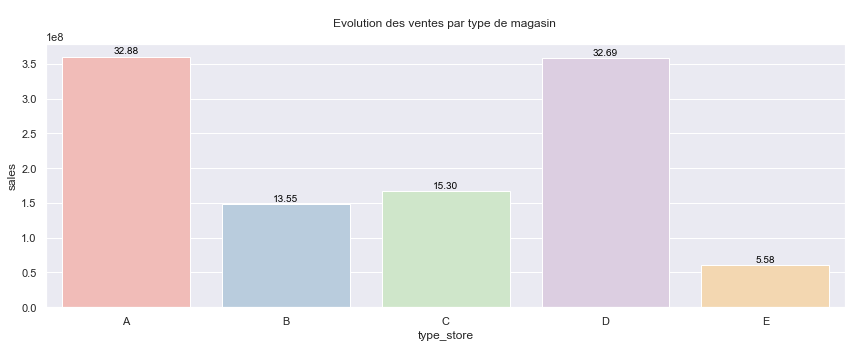

In [74]:
#Pourcentage des ventes par jour 
hoday_type_store = train_hoday_store.groupby(by = "type_store").agg({"sales": "sum"}) .reset_index()

fig, ax = plt.subplots(figsize = (12,5))

#Top 10 des secteurs d'activité sans le tremblement de terre
sns.barplot(y = "sales", x = "type_store",  data = hoday_type_store, 
                        palette = Pastel1_7.hex_colors)
plt.title("\nEvolution des ventes par type de magasin \n", fontsize = 12)


for p in ax.patches:
    ax.annotate("%.2f" % round(100*p.get_height()/train_hoday_store["sales"].sum(),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()

### Analyse des ventes par magasin et par catégorie de produit

In [75]:
train_hoday_store_nbr = train_hoday[["store_nbr","family", "sales", "Year"]]
train_hoday_store_nbr_gr= train_hoday_store_nbr.groupby(by = ["store_nbr", "family"]).sum().reset_index().sort_values(by = "sales", ascending = False)
train_hoday_store_nbr_gr = train_hoday_store_nbr_gr.rename(columns = {"store_nbr": "store"})
train_hoday_store_nbr_gr.head(2)

store     family        sales    Year
1464     45  GROCERY I  3150485.008  568209
1431     44  GROCERY I  3034203.825  568209

In [76]:
train_hoday_store_nbr_gr['store'] = 'store ' + train_hoday_store_nbr_gr.store.astype('str')
sns.set(style='white')
fig = px.bar(train_hoday_store_nbr_gr, 
             x='store', 
             y='sales', 
             color='family',
             title="Ventes par magasins et catégorie de produit entre 2013 et 2017")
fig.show()

Nous allons maintenant regarder quelles sont les régions qui réalisent le plus gros chiffre d'affaire 

In [77]:
hoday_city_store = train_hoday_store.groupby(by = ["type_store", "city"]).agg({"sales": "sum"}) .reset_index()
hoday_city_store.head()

type_store       city         sales
0          A     Ambato  2.927375e+07
1          A  Guayaquil  3.360386e+07
2          A      Manta  2.764970e+06
3          A      Quito  2.949630e+08
4          B   Babahoyo  1.814026e+07

In [78]:
train_hoday_store

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3054343  3000883 2017-08-15          9                     POULTRY   438.133   
3054344  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885 2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion     type    locale locale_name            description  \
0                  0  Holiday  National     Ecuador     Primer dia del ano   
1                  0  Holiday  National     Ecuador     Primer dia del ano   
2                  0  Holiday  National     Ecuador     Primer dia del ano   
3                  0  Holiday  National     Ecuador     Primer dia del ano   
4                  0  Holiday  National     Ecuador     Primer dia del ano   
...              ...      ...       ...         ...                    ...   
3054343            0  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054344            1  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054345          148  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054346            8  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054347            0  Holiday     Local    Riobamba  Fundacion de Riobamba   

         ...   city      state type_store cluster  weekend  weekday  Year  \
0        ...  Quito  Pichincha          D      13        0        1  2013   
1        ...  Quito  Pichincha          D      13        0        1  2013   
2        ...  Quito  Pichincha          D      13        0        1  2013   
3        ...  Quito  Pichincha          D      13        0        1  2013   
4        ...  Quito  Pichincha          D      13        0        1  2013   
...      ...    ...        ...        ...     ...      ...      ...   ...   
3054343  ...  Quito  Pichincha          B       6        0        1  2017   
3054344  ...  Quito  Pichincha          B       6        0        1  2017   
3054345  ...  Quito  Pichincha          B       6        0        1  2017   
3054346  ...  Quito  Pichincha          B       6        0        1  2017   
3054347  ...  Quito  Pichincha          B       6        0        1  2017   

         Month  day  quarter  
0            1    1   2013Q1  
1            1    1   2013Q1  
2            1    1   2013Q1  
3            1    1   2013Q1  
4            1    1   2013Q1  
...        ...  ...      ...  
3054343      8   15   2017Q3  
3054344      8   15   2017Q3  
3054345      8   15   2017Q3  
3054346      8   15   2017Q3  
3054347      8   15   2017Q3  

[3054348 rows x 21 columns]

In [79]:

fig = px.bar(hoday_city_store, 
             x='city', 
             y='sales', 
             color='type_store',
             #animation_frame='type_store',
             title="type de magasin, cluster et numéro de magasin")
fig.show()

# correlation entre magasin et vente 

<ipython-input-81-c0bce18967d0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-81-c0bce18967d0>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



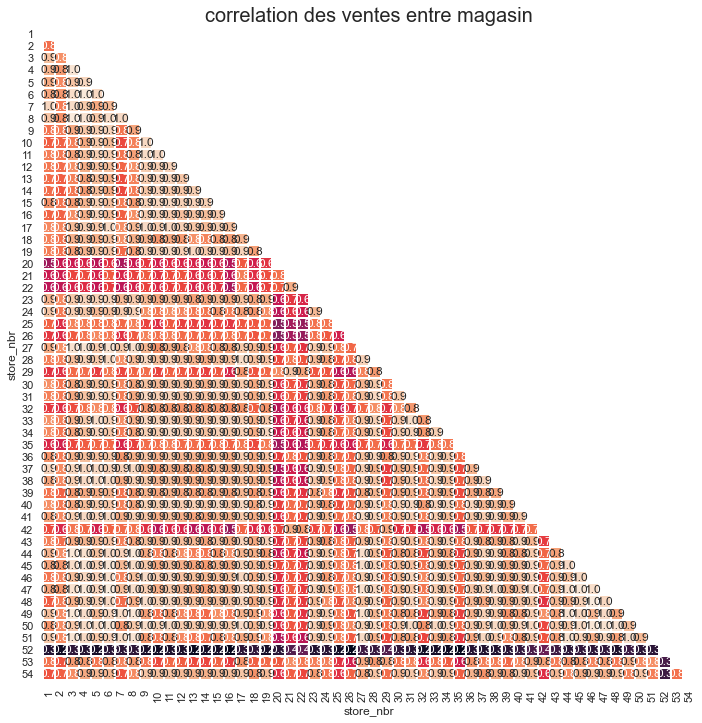

In [81]:
correlation = train_hoday_store[["store_nbr", "sales"]]
correlation["ind"] = 1 # creation de la colonne des 1

# cumuler la colonne des 1 jusqu'à la dernière observation
correlation["ind"] = correlation.groupby("store_nbr").ind.cumsum().values

#  tableau croisé dynamique de corrélation entre les ventes de chaque magasins
correlation = pd.pivot_table(correlation, index= "ind", columns = "store_nbr", values = "sales").corr()

# on fait un slice du dessus du  triangle

mask = np.triu(correlation.corr())

plt.figure(figsize = (12,12))
sns.heatmap(correlation,
           annot = True,
           fmt = '.1f', 
           square = True, 
           mask = mask, 
           linewidths = 1,
           cbar = False)
plt.title( "correlation des ventes entre magasin", fontsize = 20)
plt.show()

## Correlation entre les ventes et les promotions : Corrélation entre deux variables quantitatives

In [82]:
# Calcul du coefficient de Pearson
print(st.pearsonr(train_hoday_store["sales"],train_hoday_store["onpromotion"]))

(0.4282410665192658, 0.0)


# Etape 2 prédiction des ventes 

In [83]:
prediction = train_hoday_store.groupby(by = ["date", "family"]).agg({"sales":"mean"}).reset_index().set_index("date")
prediction

family        sales
date                                               
2013-01-01                  AUTOMOTIVE     0.000000
2013-01-01                   BABY CARE     0.000000
2013-01-01                      BEAUTY     0.037037
2013-01-01                   BEVERAGES    15.000000
2013-01-01                       BOOKS     0.000000
...                                ...          ...
2017-08-15                     POULTRY   325.679815
2017-08-15              PREPARED FOODS    85.954129
2017-08-15                     PRODUCE  2316.832796
2017-08-15  SCHOOL AND OFFICE SUPPLIES    46.851852
2017-08-15                     SEAFOOD    17.966241

[55572 rows x 2 columns]

In [84]:
prediction.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [85]:
prediction_grocery = prediction.loc[prediction["family"] == "GROCERY I"]
prediction_grocery

family        sales
date                              
2013-01-01  GROCERY I    12.962963
2013-01-02  GROCERY I  3741.111111
2013-01-03  GROCERY I  2682.925926
2013-01-04  GROCERY I  2513.962963
2013-01-05  GROCERY I  3488.074074
...               ...          ...
2017-08-11  GROCERY I  4411.517074
2017-08-12  GROCERY I  4419.030241
2017-08-13  GROCERY I  4785.971333
2017-08-14  GROCERY I  4173.253593
2017-08-15  GROCERY I  4152.002315

[1684 rows x 2 columns]

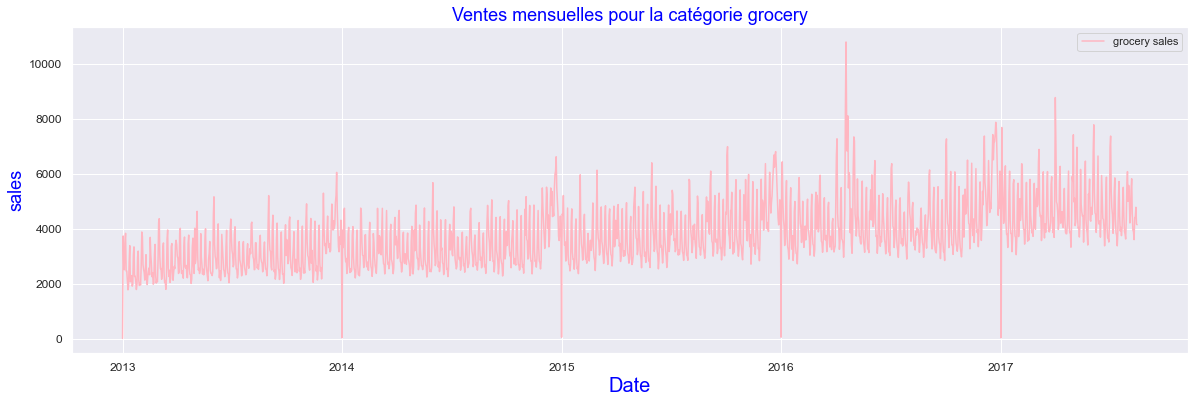

In [86]:
# Figure de la consommation électrique ajustée 
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure

x = prediction_grocery.index
y = prediction_grocery["sales"]


plt.plot(x, y, color = "lightpink", label = "grocery sales")

# Métadonnées
plt.title("Ventes mensuelles pour la catégorie grocery", fontsize = 18, color = "blue")
plt.ylabel("sales", fontsize = 18, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Sauvegarder la figure 



plt.legend()

On va d'abord effectuer une désaisonnalisation grâce aux moyennes mobiles.

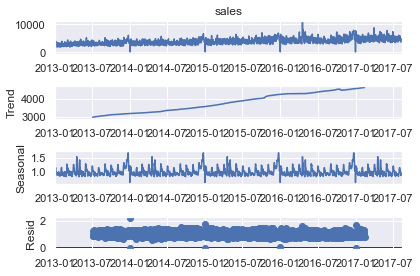

In [87]:
decomp_x = seasonal_decompose(prediction_grocery["sales"]  ,  model='multiplicative', period= 365)
decomp_x.plot()
plt.show()

In [88]:
#Nous allons créer un dataframe qui contiendra les valeurs de la décomposition saisonière( valeurs désaisonnalisées) 
data_seasonal = pd.DataFrame(decomp_x.seasonal)
data_seasonal

seasonal
date                
2013-01-01  1.202883
2013-01-02  1.112670
2013-01-03  1.139278
2013-01-04  1.137503
2013-01-05  1.045780
...              ...
2017-08-11  0.926160
2017-08-12  0.894085
2017-08-13  0.945146
2017-08-14  0.884449
2017-08-15  0.920150

[1684 rows x 1 columns]

In [89]:
seasonal = pd.merge(prediction_grocery, data_seasonal, right_on = "date", left_on = "date")
seasonal = seasonal.rename(columns = {"seasonal": "valeurs_saisonnieres"})
seasonal

family        sales  valeurs_saisonnieres
date                                                    
2013-01-01  GROCERY I    12.962963              1.202883
2013-01-02  GROCERY I  3741.111111              1.112670
2013-01-03  GROCERY I  2682.925926              1.139278
2013-01-04  GROCERY I  2513.962963              1.137503
2013-01-05  GROCERY I  3488.074074              1.045780
...               ...          ...                   ...
2017-08-11  GROCERY I  4411.517074              0.926160
2017-08-12  GROCERY I  4419.030241              0.894085
2017-08-13  GROCERY I  4785.971333              0.945146
2017-08-14  GROCERY I  4173.253593              0.884449
2017-08-15  GROCERY I  4152.002315              0.920150

[1684 rows x 3 columns]

In [90]:
# Nous allons ajouter la colonne valeurs désaisonnalisées qui s'est affranchit de l'impact saisonier

seasonal["cvs"] = seasonal["sales"] - seasonal["valeurs_saisonnieres"] 
#seasonal= seasonal.reset_index()
seasonal.head()

family        sales  valeurs_saisonnieres          cvs
date                                                                 
2013-01-01  GROCERY I    12.962963              1.202883    11.760080
2013-01-02  GROCERY I  3741.111111              1.112670  3739.998441
2013-01-03  GROCERY I  2682.925926              1.139278  2681.786648
2013-01-04  GROCERY I  2513.962963              1.137503  2512.825460
2013-01-05  GROCERY I  3488.074074              1.045780  3487.028294

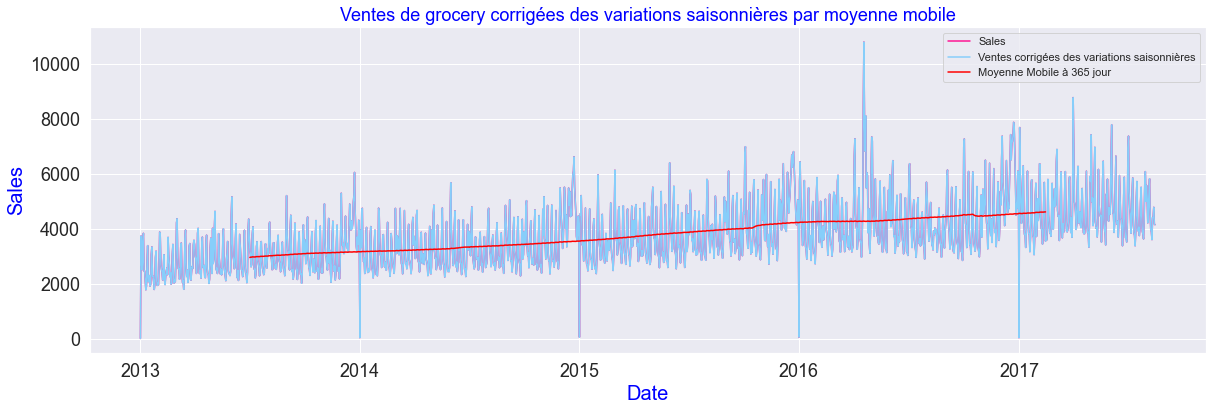

In [91]:
sns.set(style = "darkgrid")
plt.figure(figsize = (20,6))

# Variables de la figure
x1 = seasonal.index
y1 = seasonal["sales"]
x2 = seasonal.index
y2 = seasonal["cvs"]
x3 = seasonal.index
y3 = seasonal["cvs"].rolling(365, center=True).mean()

plt.plot(x1, y1, color = "deeppink", label = "Sales")
plt.plot(x2, y2, color = "lightskyblue", label = "Ventes corrigées des variations saisonnières")
plt.plot(x3,y3, color = "red", label='Moyenne Mobile à 365 jour')

# Métadonnées
plt.title("Ventes de grocery corrigées des variations saisonnières par moyenne mobile", fontsize = 18, color = "blue")
plt.ylabel("Sales", fontsize = 20, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 

plt.legend()

## Prévoyez une série à l’aide des méthodes de lissage exponentiel: La méthode de Holt Winters

In [92]:
y = np.asarray(seasonal["cvs"])
holt_winter = ExponentialSmoothing(y, trend = "mul", seasonal_periods = 365, seasonal = "mul").fit()
 
holt_winter_pred = holt_winter.forecast(365) # On utilise ici le forecast sur 12 mois 
                                            #afin de prévoir la consommation électrique
                                           # sur cette période pour l'année avenir 



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



### Prédiction de la prévision sur 12 mois pour l'année 2018

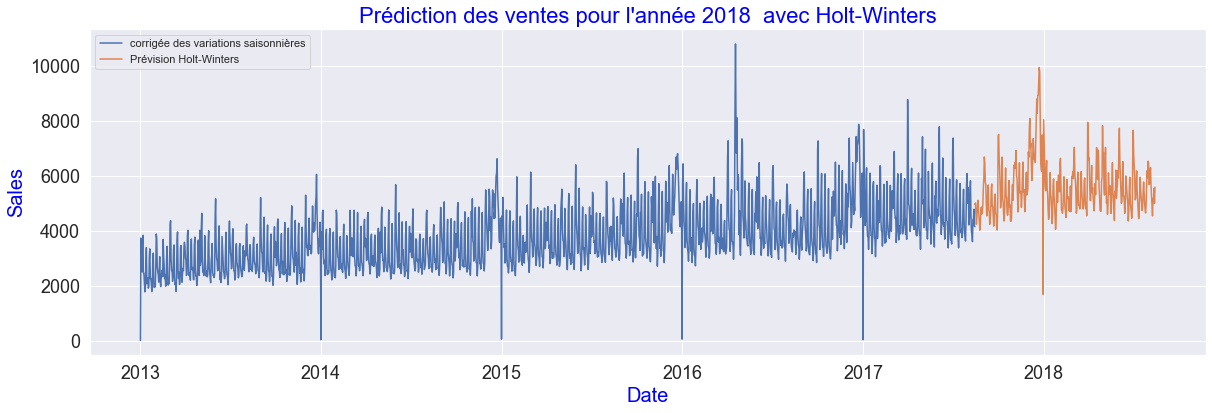

In [93]:
plt.figure(figsize = (20,6))
plt.plot(seasonal["cvs"], label='corrigée des variations saisonnières')
plt.plot(pd.date_range(seasonal.index[len(y)-1], periods=365, freq='D'),
                                          holt_winter_pred, label='Prévision Holt-Winters')

# Métadonnées
plt.title("Prédiction des ventes pour l'année 2018  avec Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Sales", fontsize = 20, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("Prévision_2018_Holt_Winters.png")

plt.legend()
plt.show()

### Analyse a posteriori

In [94]:
# Troncature du dataset qui va de l'année 2021 à l'année 2021
x_tronc = seasonal["2013":'2016':]
# l'année à prévoir 2020
x_a_prevoir = seasonal['2016']

<ipython-input-94-cd18fbe2fe0b>:4: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [95]:
y_x_tronc= x_tronc['sales']
holt_winter2 = ExponentialSmoothing(y_x_tronc, seasonal_periods = 365, trend = "mul", seasonal = "mul").fit()
holt_winter_pred2 = holt_winter2.forecast(365)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



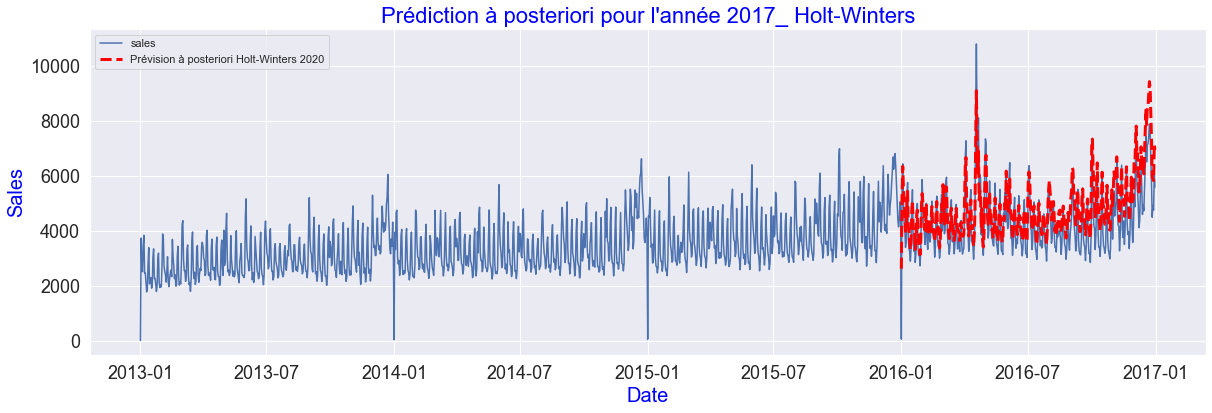

In [96]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc["sales"], label='sales')
plt.plot(x_a_prevoir.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("Prédiction à posteriori pour l'année 2017_ Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Sales", fontsize = 20, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("a_posteriori_2017_Holt_Winters.png")


plt.legend()
plt.show()

In [97]:
zoom_x_tronc = seasonal['2016']

<ipython-input-97-b61575d75622>:1: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



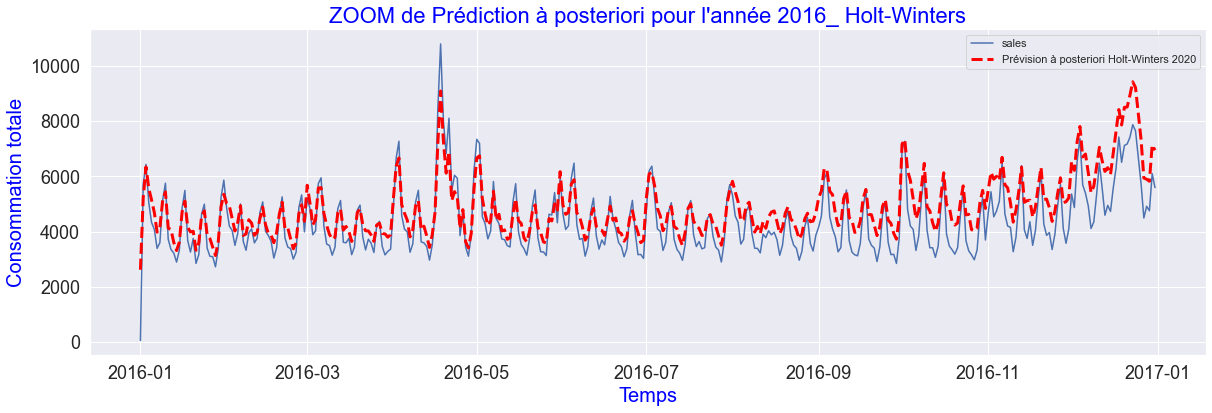

In [98]:
plt.figure(figsize = (20,6))
plt.plot(zoom_x_tronc['sales'] , label='sales')
plt.plot(x_a_prevoir.index, holt_winter_pred2, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2020', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("ZOOM de Prédiction à posteriori pour l'année 2016_ Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Consommation totale", fontsize = 20, color = "blue")
plt.xlabel("Temps", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

### Evaluation du modèle

In [99]:
# Root Mean square error( erreur quadratique moyenne)
rmse = round(np.sqrt(((x_a_prevoir['sales']-holt_winter_pred)**2).mean()),2)
rmse

2005.99

In [100]:
# l'erreur relative absolue moyenne MAPE (Mean Average Percentage Error)
mape=(np.abs(1-holt_winter_pred/x_a_prevoir['sales'])).mean()*100
mape

64.95914465320452

In [101]:
#Fonction de calculs des metriques importantes MAE, MSE, MAPE, RMSE, R²
def metrics_timeseries(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(diff / y_true)) * 100
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "MSE", "RMSE", "MAPE", "R²"], "Résultats":[mae, mse, rmse, mape, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [102]:
df_metrics_holt_winters = metrics_timeseries(x_a_prevoir['sales'], holt_winter_pred)
df_metrics_holt_winters

Métrique     Résultats
0      MAE  1.646252e+03
1      MSE  4.023998e+06
2     RMSE  2.005990e+03
3     MAPE  6.495914e+01
4       R² -1.834756e+00

### Prévision sur 24 Mois

In [103]:
# Troncature du dataset qui va de l'année 2021 à l'année 2021


In [104]:
# l'année à prévoir 2015_2017
x_tronc2 = seasonal["2015":'2017':]

y_x_tronc= x_tronc['sales']
holt_winter3 = ExponentialSmoothing(y_x_tronc, seasonal_periods = 956, trend = "mul", seasonal = "mul").fit()
holt_winter_pred3 = holt_winter3.forecast(956)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



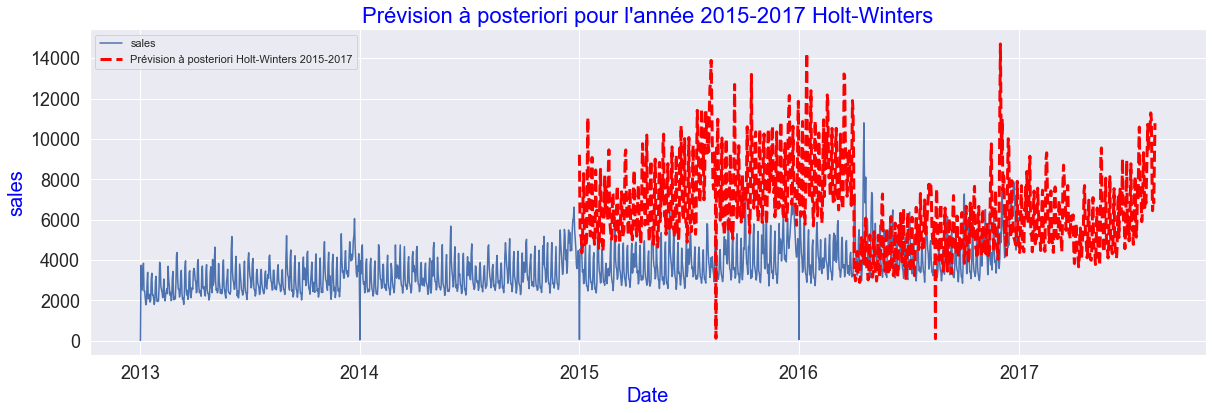

In [105]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc["sales"], label='sales')
plt.plot(x_tronc2.index, holt_winter_pred3, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2015-2017', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("Prévision à posteriori pour l'année 2015-2017 Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("sales", fontsize = 20, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("a_posteriori_15_17_Holt_Winters.png")


plt.legend()
plt.show()

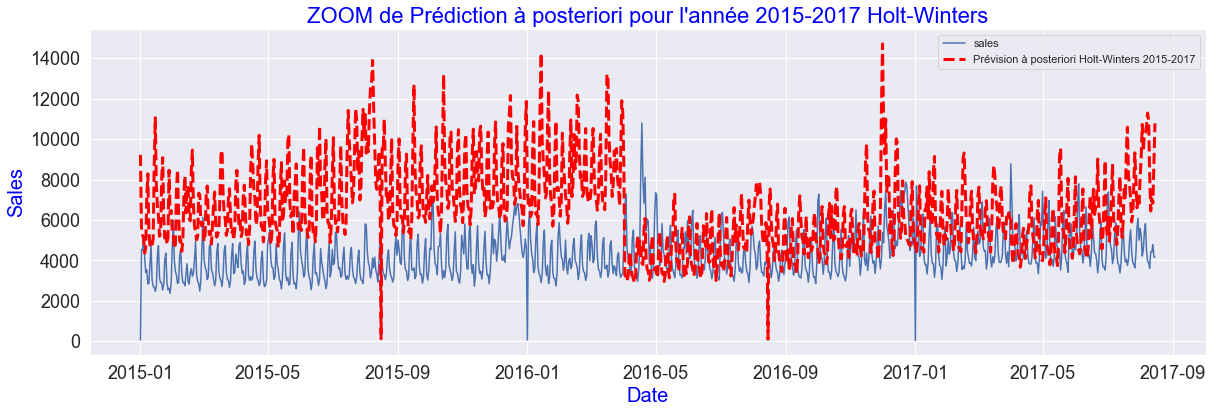

In [106]:
plt.figure(figsize = (20,6))
plt.plot(x_tronc2['sales'] , label='sales')
plt.plot(x_tronc2.index, holt_winter_pred3, color = 'red', 
         label =  'Prévision à posteriori Holt-Winters 2015-2017', linestyle = 'dashed', lw = 3)

# Métadonnées
plt.title("ZOOM de Prédiction à posteriori pour l'année 2015-2017 Holt-Winters", fontsize = 22, color = "blue")
plt.ylabel("Sales", fontsize = 20, color = "blue")
plt.xlabel("Date", fontsize = 20, color = "blue")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Sauvegarder la figure 
#plt.savefig("a_posteriori_2020_Holt_Winters.png")


plt.legend()
plt.show()

Ici on voit que les prévisions à 24 mois ne sont plus robustes. Toutefois avec ce modèle on peut prédir correctement les ventes hebdomadaires, mensuelles et trimestrielles

# Prédiction en utilisant le modèle de Sarima 

## Test si la série est stationnaire

In [107]:
result = adfuller(seasonal.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.448763
p-value: 0.009405


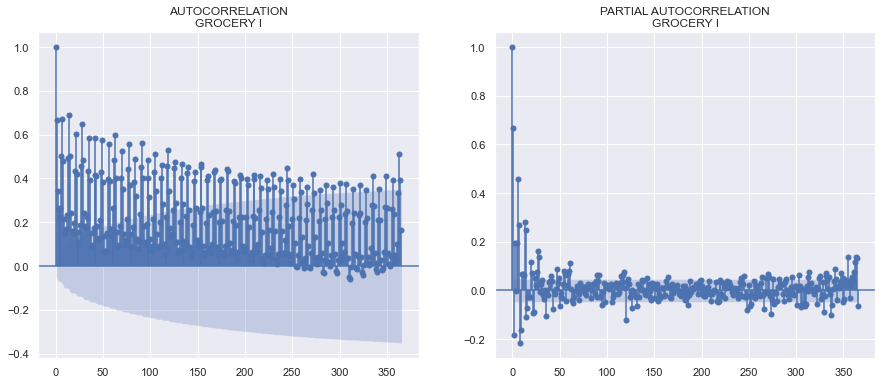

In [108]:
for num, i in enumerate(seasonal.family.unique()):
    try: 
        fig, ax = plt.subplots(1,2, figsize = (15,6))
        temp = seasonal[seasonal.family ==i] # pour prediction.sales.notnull()
        sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "AUTOCORRELATION\n" + i)
        sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)
    except:
        pass
        

### Construire le modèle SARIMA 

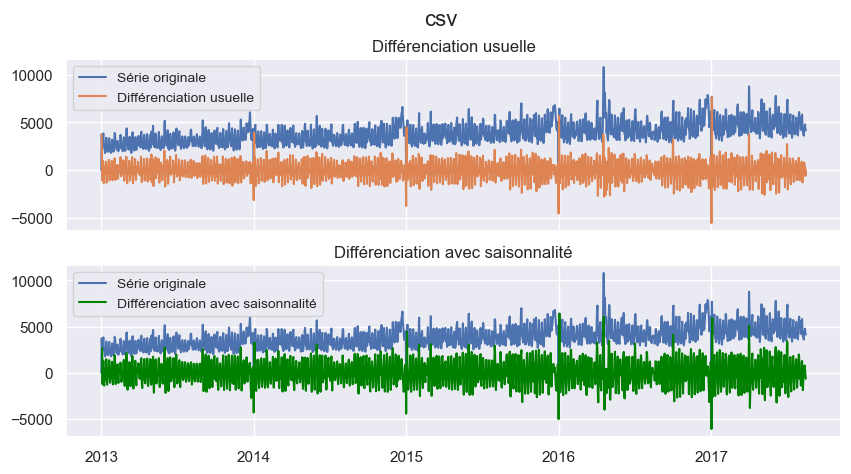

In [109]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Série différenciée une fois
axes[0].plot(seasonal.sales[:], label='Série originale')
axes[0].plot(seasonal.sales[:].diff(1), label='Différenciation usuelle')
axes[0].set_title('Différenciation usuelle')
axes[0].legend(loc='upper left', fontsize=10)


# Série différenciée douze fois
axes[1].plot(seasonal.sales[:], label='Série originale')
axes[1].plot(seasonal.sales[:].diff(2), label='Différenciation avec saisonnalité', color='green')
axes[1].set_title('Différenciation avec saisonnalité')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle("csv", fontsize=16)
plt.show()

In [110]:
sarima_df = seasonal[["cvs"]]
sarima_df

cvs
date                   
2013-01-01    11.760080
2013-01-02  3739.998441
2013-01-03  2681.786648
2013-01-04  2512.825460
2013-01-05  3487.028294
...                 ...
2017-08-11  4410.590914
2017-08-12  4418.136155
2017-08-13  4785.026187
2017-08-14  4172.369143
2017-08-15  4151.082165

[1684 rows x 1 columns]

In [111]:
from pmdarima import auto_arima

In [112]:
#help(auto_arima)

In [113]:
from statsmodels.tsa.arima_model import ARIMA

# 1,0,2 ARIMA Model
model = ARIMA(sarima_df.cvs, order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

print('Retard : p-value')
for elt in [7,14, 18, 20, 30]:
    print('{} : {}'.format(elt, acorr_ljungbox(model_fit.resid, lags=elt)[1].mean()))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. foreca

                              ARMA Model Results                              
Dep. Variable:                    cvs   No. Observations:                 1684
Model:                     ARMA(1, 2)   Log Likelihood              -13598.263
Method:                       css-mle   S.D. of innovations            776.903
Date:                Sat, 26 Mar 2022   AIC                          27206.526
Time:                        10:44:36   BIC                          27233.671
Sample:                             0   HQIC                         27216.580
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3740.1450    568.997      6.573      0.000    2624.932    4855.358
ar.L1.cvs      0.9987      0.002    651.293      0.000       0.996       1.002
ma.L1.cvs     -0.3508      0.019    -18.910      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



In [114]:
shapiro_test = shapiro(model_fit.resid)
shapiro_test.pvalue

1.040793534583256e-27

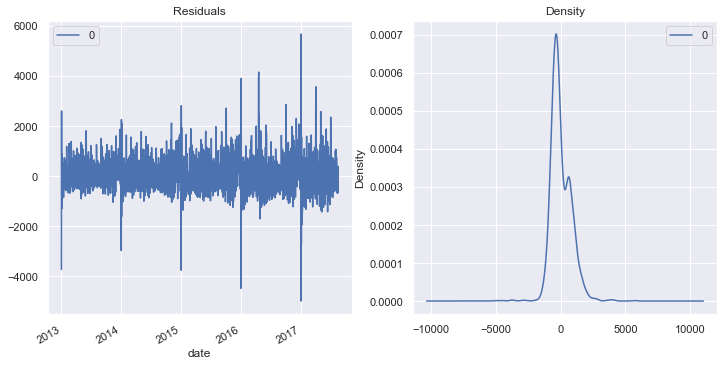

In [115]:
# Visualisation de la normalité des résidus 

residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1,2, figsize = (12,6))

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Traçons les valeurs réelles par rapport aux valeurs ajustées en utilisant

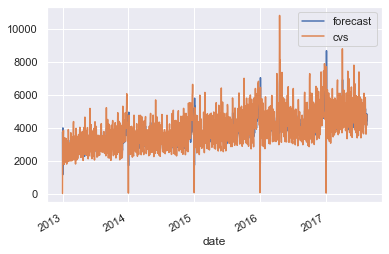

In [116]:
# valeurs Actuelles vs valeurs ajustée
model_fit.plot_predict(dynamic=False)
plt.show()

Nous allons passer à la validation du modèle en faisant quelques prédictions 

In [117]:
#Nous allons créer des données d'entrainement et des données de test
train_sarima = sarima_df.cvs[:1263] # On prend 75% des données
test = sarima_df.cvs[1263:]
test


date
2016-06-20    4109.134090
2016-06-21    3611.951012
2016-06-22    3466.427041
2016-06-23    3090.071749
2016-06-24    3382.547155
                 ...     
2017-08-11    4410.590914
2017-08-12    4418.136155
2017-08-13    4785.026187
2017-08-14    4172.369143
2017-08-15    4151.082165
Name: cvs, Length: 421, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. foreca

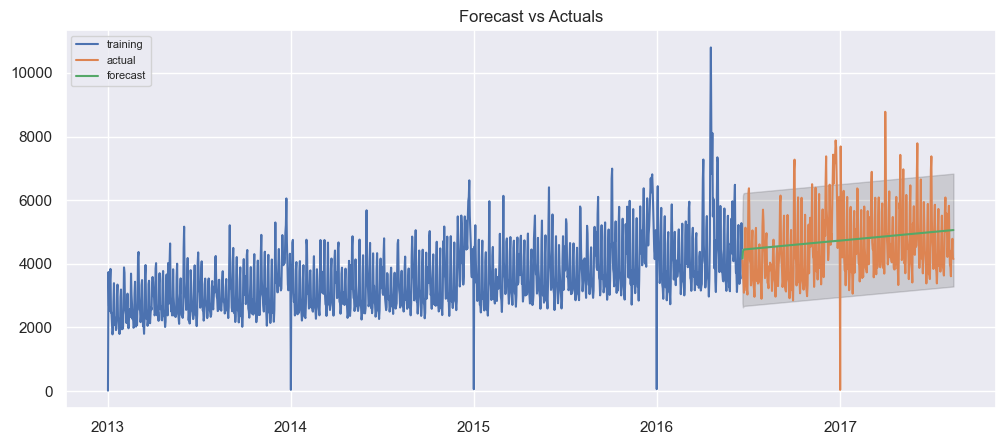

In [118]:
# Construction du modèle
# model = ARIMA(train, order=(1,1,2))  
model = ARIMA(train_sarima, order=(1, 1, 2))  
fitted = model.fit(disp=0)  

# prédiction
fc, se, conf = fitted.forecast(421, alpha=0.05)  # 95% intervalle de confiance 

# pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_sarima, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import

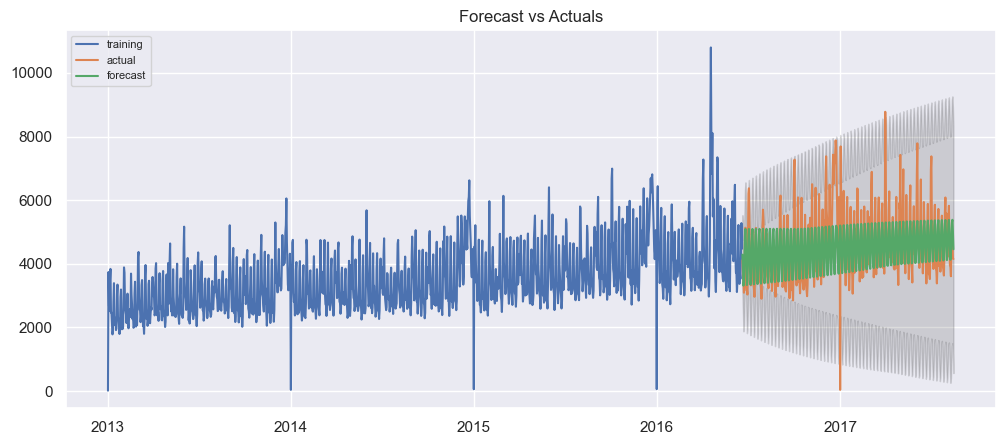

In [119]:
# Construction du modèle
# model = ARIMA(train, order=(1,1,2))  
model = ARIMA(train_sarima, order=(3, 1, 4))  
fitted = model.fit(disp=0)  

# prédiction
fc, se, conf = fitted.forecast(421, alpha=0.05)  # 95% intervalle de confiance 

# pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_sarima, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Mesures de précision pour les prévisions de séries chronologiques

In [120]:
# Métriques de précision
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



{'mape': 0.4709798404546245,
 'me': -62.98335398780701,
 'mae': 642.368009601376,
 'mpe': 0.35103333036458767,
 'rmse': 872.9912425036489,
 'acf1': 0.43030041749309006,
 'corr': 0.5999285291140227,
 'minmax': 0.12494070344461428}

## Auto Arima

In [121]:
import pmdarima as pm
model3 = pm.auto_arima(sarima_df.cvs, start_p=1, start_q=1,
                      test='adf',       # utilise le test de adf pour trouver le d optimal
                      max_p=6, max_q=6, # p et  q max
                      m=365,              # fréquence de la série
                      d=None,           # ici c'est le modèle qui détermine le d
                      seasonal=False,   # pas de saisonalité
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model3.summary())

C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (365) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=27786.293, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32669.275, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=27784.617, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30755.248, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=27786.572, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=27739.949, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=27190.723, Time=1.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=27568.017, Time=0.20 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=27217.415, Time=1.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=27384.342, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=27192.863, Time=0.97 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=27553.031, Time=0.29 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=27447.261, Time=1.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=27380.583, Time=0.46 sec

Best model:  ARIMA

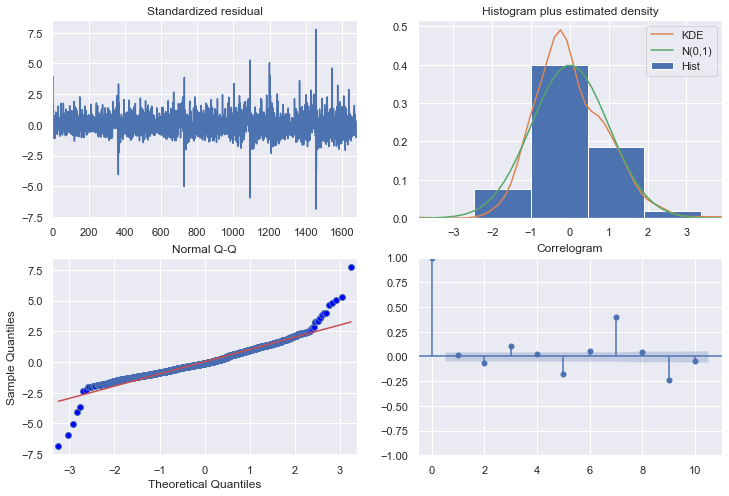

In [122]:

model3.plot_diagnostics(figsize=(12,8))
plt.show()


In [123]:

model3tronc = ARIMA(np.asarray(x_tronc['sales']), order=(3,0,1))
results3tronc = model3tronc.fit()
print(results3tronc.summary())

print('Retard : p-value')
for elt in [30, 60, 90, 120, 150, 365]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3tronc.resid, lags=elt)[1].mean()))
    


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1457
Model:                     ARMA(3, 1)   Log Likelihood              -11677.216
Method:                       css-mle   S.D. of innovations            731.248
Date:                Sat, 26 Mar 2022   AIC                          23366.432
Time:                        10:44:54   BIC                          23398.137
Sample:                             0   HQIC                         23378.261
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3894.8561    656.834      5.930      0.000    2607.486    5182.226
ar.L1.y        1.6803      0.027     62.664      0.000       1.628       1.733
ar.L2.y       -1.0543      0.042    -24.883      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.

